# **Avance 5 · Modelo Final**
**Fecha:** 2025-10-19 19:35
Curso: TC5035 - Proyecto Integrador

Tecnológico de Monterrey

Prof Horacio Martínez Alfaro

Módulo 3 Ingeniería y evaluación de modelos

Equipo 18

Joaquín Díaz Hernández - A01281536

Divad Alejandro Shriqui Garrón - A01366907

Manuel Romero Alvarez - A00567983

## **Parámetros**

In [10]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [11]:
DATA_PATH = '/content/drive/MyDrive/MNA - Proyecto Integrador/Semana 7/dataset_modelo_v2.csv'

TARGET_COL = 'Desc.1'
RANDOM_STATE = 42
RANDOM_STATE_ALT = 99
TEST_SIZE = 0.30

## **Librerías**

In [12]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import time

from sklearn.model_selection import (train_test_split, StratifiedKFold,
                                     cross_val_score, learning_curve,
                                     GridSearchCV)
from sklearn.preprocessing import StandardScaler, LabelEncoder, label_binarize
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.metrics import (accuracy_score, f1_score, classification_report,
                             precision_score, recall_score,
                             confusion_matrix, ConfusionMatrixDisplay,
                             roc_curve, auc, precision_recall_curve,
                             average_precision_score)
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import (RandomForestClassifier, StackingClassifier)
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier
from sklearn.svm import SVC
from sklearn.naive_bayes import GaussianNB
from sklearn.neighbors import KNeighborsClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.multiclass import OneVsRestClassifier
from sklearn.tree import plot_tree

## **1. Ensambles**

En esta etapa se busca evaluar el desempeño del modelo Random Forest, seleccionado en la entrega anterior, frente a una serie de modelos de ensamble, los cuales combinan múltiples estimadores con el objetivo de aumentar la precisión, la estabilidad y la capacidad de generalización del sistema de clasificación de tickets.
Si bien el Random Forest también pertenece a la familia de los modelos de ensamble, se trata de uno de los enfoques más comunes; por ello, en esta fase se incorporan otros métodos más avanzados para analizar posibles mejoras en el rendimiento.

Los métodos de ensamble parten del principio de que la combinación de varios modelos débiles o complementarios puede generar un predictor más fuerte.
De acuerdo con su composición, pueden clasificarse en dos grandes grupos:

- Ensambles homogéneos, que utilizan múltiples modelos del mismo tipo (por ejemplo, árboles de decisión) combinados mediante estrategias como bagging o boosting.

- Ensambles heterogéneos, que integran modelos de distinta naturaleza (por ejemplo, SVM, Random Forest y Regresión Logística) mediante métodos de stacking o blending.

En las siguientes subsecciones se implementan ambos enfoques, aplicando una optimización de hiperparámetros para los modelos más relevantes y evaluando su rendimiento mediante validación cruzada estratificada.

### 1.0 Carga de Datos y visualización (apoyo)

Carga de datos, revisión rápida de nulos y balance de clases.

Shape: (15483, 21)


,Moneda_USD,Cargo_bin_Bajo,Cargo_bin_Medio,Cargo_bin_Muy alto,Desc_0,Desc_1,Desc_2,Desc_3,Desc_4,Desc_5,...,Desc_7,Desc_8,Desc_9,Desc_10,Desc_11,Desc_12,Cargo,CpnyID_dt_year,CpnyID_dt_month,Desc.1
0,0.0,0.0,1.0,0.0,0,0,0,0,0,0,...,0,0,0,0,0,1,-0.480301,-0.652248,-1.733524,Alimentacion
1,0.0,0.0,1.0,0.0,0,0,0,0,0,0,...,0,0,0,0,1,0,-0.588373,-0.652248,-1.733524,Alimentacion
2,0.0,0.0,1.0,0.0,0,0,0,0,0,0,...,0,0,0,0,1,1,-0.514855,-0.652248,-1.733524,Alimentacion
3,0.0,0.0,1.0,0.0,0,0,0,0,0,0,...,0,0,0,1,0,0,-0.550221,-0.652248,-1.733524,Alimentacion
4,0.0,1.0,0.0,0.0,0,0,0,0,0,0,...,0,0,0,1,0,1,-2.122670,-0.652248,-1.733524,Alimentacion



Distribución de clases (proporción):


,proportion
Desc.1,
Alimentacion,0.679584
Transportacion,0.173997
Hotel,0.146419


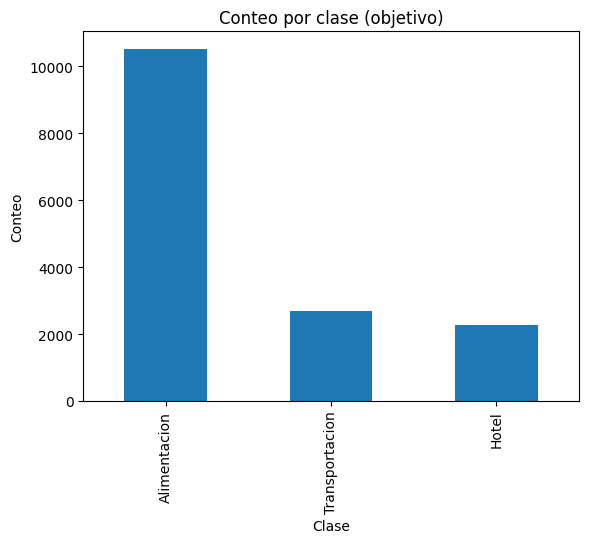


Nulos por columna (top 20):


,0
Moneda_USD,0
Cargo_bin_Bajo,0
Cargo_bin_Medio,0
Cargo_bin_Muy alto,0
Desc_0,0
Desc_1,0
Desc_2,0
Desc_3,0
Desc_4,0
Desc_5,0


In [13]:
np.random.seed(RANDOM_STATE)

# === Carga y limpieza básica ===
df = pd.read_csv(DATA_PATH, index_col=0)

# 1) Eliminar columna artefacto (si existe)
if 'Unnamed: 0' in df.columns:
    df = df.drop(columns=['Unnamed: 0'])

print('Shape:', df.shape)
display(df.head())

# 2) Validación de target
if TARGET_COL not in df.columns:
    raise ValueError(f"TARGET_COL '{TARGET_COL}' no existe. Columnas: {df.columns.tolist()}")

# 4) Balance de clases
y_full = df[TARGET_COL]
print('\nDistribución de clases (proporción):')
display(y_full.value_counts(normalize=True).rename('proportion').to_frame())

fig, ax = plt.subplots()
y_full.value_counts().plot(kind='bar', ax=ax)
ax.set_title('Conteo por clase (objetivo)')
ax.set_xlabel('Clase'); ax.set_ylabel('Conteo')
plt.show()

# 5) Nulos
print('\nNulos por columna (top 20):')
display(df.isnull().sum().sort_values(ascending=False).head(20))

El conjunto de datos es el mismo que se utilizó a lo largo de la entrega pasada ya con todas las transformaciones necesarias. Cuenta con 15,483 registros y 21 variables (20 variables predictoras + 1 varaible objetivo), representando transacciones clasificadas en tres categorías principales: Alimentación (67.96%), Transportación (17.40%) y Hotel (14.64%). Como declaramos en la entrega pasada esta distribución evidencia un moderado desbalance de clases, lo cual justifica el uso de particiones estratificadas en el entrenamiento y la evaluación del modelo, así como la elección de F1 macro como métrica principal para garantizar una valoración equilibrada entre clases.

Para asegurar una evaluación justa del modelo de clasificación de gastos, se realiza una partición estratificada del dataset:

- 70 % de los datos se utilizan para el entrenamiento del modelo,
- 15 % para la validación de hiperparámetros, y
- 15 % para la evaluación final sobre datos no vistos.

Esta división mantiene la proporción original de las categorías de gasto (`Desc.1`) en cada subconjunto, evitando sesgos en el aprendizaje.

In [14]:
X = df.drop(columns=[TARGET_COL]); y = df[TARGET_COL]

X_train, X_temp, y_train, y_temp = train_test_split(X, y, test_size=0.3, stratify=y, random_state=RANDOM_STATE)
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5, stratify=y_temp, random_state=RANDOM_STATE)

In [15]:
# Mostrar tamaños relativos
n_total = len(df)
print("Tamaños de los conjuntos:")
print(f"Train: {len(X_train)} ({len(X_train)/n_total:.1%})")
print(f"Val:   {len(X_val)} ({len(X_val)/n_total:.1%})")
print(f"Test:  {len(X_test)} ({len(X_test)/n_total:.1%})\n")

# Verificar que las proporciones de clases se mantienen
print("Distribución de clases en cada conjunto (%):\n")
dist_df = pd.DataFrame({
    'Total': y.value_counts(normalize=True) * 100,
    'Train': y_train.value_counts(normalize=True) * 100,
    'Val': y_val.value_counts(normalize=True) * 100,
    'Test': y_test.value_counts(normalize=True) * 100
}).round(2)

display(dist_df)

Tamaños de los conjuntos:
Train: 10838 (70.0%)
Val:   2322 (15.0%)
Test:  2323 (15.0%)

Distribución de clases en cada conjunto (%):



,Total,Train,Val,Test
Desc.1,,,,
Alimentacion,67.96,67.96,67.96,67.97
Transportacion,17.40,17.40,17.40,17.39
Hotel,14.64,14.64,14.64,14.64


In [16]:
resultados = []

### 1.1 Ensambles homogéneos

En esta subsección se desarrollan modelos de ensamble homogéneos, es decir, aquellos que combinan múltiples estimadores del mismo tipo con el propósito de reducir la varianza y mejorar la capacidad de generalización.
En particular, se implementan dos enfoques basados en boosting: XGBoost y LightGBM, ambos construidos sobre árboles de decisión y orientados a optimizar el error de manera secuencial.

Estos modelos permiten comparar distintas estrategias de boosting en términos de desempeño (F1-macro) y eficiencia computacional frente al modelo base de Random Forest.

#### 1.1.0 Mejor modelo RF y SVC

En esta sección se presentan los modelos Random Forest y SVC, los cuales destacaron como los mejores en la entrega anterior.

Estos modelos se utilizarán como base para la construcción de los modelos heterogéneos y posteriormente para realizar la comparación final con los demás modelos de ensamble desarrollados en este notebook.


Duración del entrenamiento (s) - RF (ajustado): 0.6029701232910156

Classification report RF
                precision    recall  f1-score   support

  Alimentacion      0.988     0.990     0.989      1578
         Hotel      0.967     0.947     0.957       340
Transportacion      0.971     0.978     0.974       404

      accuracy                          0.982      2322
     macro avg      0.975     0.972     0.973      2322
  weighted avg      0.982     0.982     0.982      2322



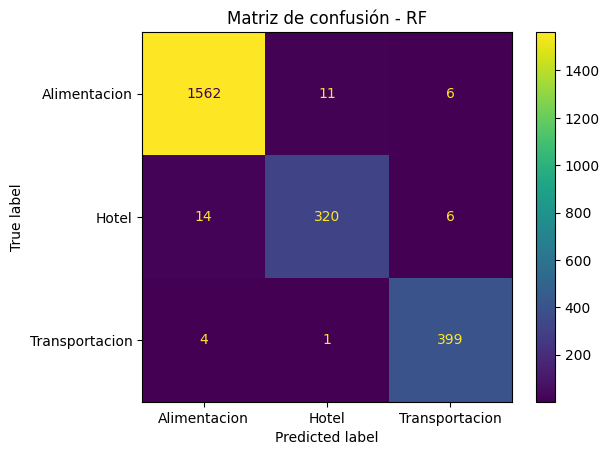

In [17]:
# Modelo Final RF obtenido en la entrega anterior (Avance 4)
best_rf  = RandomForestClassifier(n_estimators=100, max_depth=None, min_samples_split=2, min_samples_leaf=1, random_state=RANDOM_STATE, n_jobs=-1)

# Entrenamiento y duración
inicio = time.time()
best_rf.fit(X_train, y_train)
fin = time.time()

# Evaluación en el conjunto de validación
y_tr = best_rf.predict(X_train)
y_pred = best_rf.predict(X_val)

# Métricas
acc = accuracy_score(y_val, y_pred)
precision = precision_score(y_val, y_pred, average='macro', zero_division=0)
recall = recall_score(y_val, y_pred, average='macro', zero_division=0)
f1 = f1_score(y_val, y_pred, average='macro')
time_rf = fin - inicio
print(f"\nDuración del entrenamiento (s) - RF (ajustado): {time_rf}")

# Reporte de clasificación
print(f'\nClassification report RF')
print(classification_report(y_val, y_pred, digits=3))

# Matriz de confusión
ConfusionMatrixDisplay.from_estimator(best_rf, X_test, y_test)
plt.title(f'Matriz de confusión - RF'); plt.show()

# Guardar resultados
resultados.append({
    "Modelo": 'RF',
    "F1-Score (macro)": round(f1, 4),
    "Accuracy": round(acc, 4),
    "Precision (macro)": round(precision, 4),
    "Recall (macro)": round(recall, 4),
    "Tiempo de entrenamiento (s)": round(time_rf, 3)
})

In [18]:
# --- Validación cruzada para el modelo RF ---

# Definir validación cruzada estratificada
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=RANDOM_STATE)

# Medir duración
inicio = time.time()

# Validación cruzada (F1 macro)
f1_scores = cross_val_score(
    best_rf,
    X_train,
    y_train,
    cv=cv,
    scoring='f1_macro',
    n_jobs=-1
)

fin = time.time()
duracion_cv = fin - inicio

# Crear DataFrame de resultados
df_resultadoscv = pd.DataFrame([{
    "Model": "RF",
    "F1-avg": round(np.mean(f1_scores), 4),
    "F1-Std. Dev": round(np.std(f1_scores, ddof=1), 4)
}])

print(f"Duración total de la validación cruzada (s): {duracion_cv:.3f}")
df_resultadoscv.iloc[[0]]


Duración total de la validación cruzada (s): 5.127


,Model,F1-avg,F1-Std. Dev
0,RF,0.974,0.003



Duración del entrenamiento (s) - SVM (ajustado): 1.0851030349731445

Classification report SVM
                precision    recall  f1-score   support

  Alimentacion      0.987     0.990     0.989      1578
         Hotel      0.961     0.950     0.956       340
Transportacion      0.983     0.978     0.980       404

      accuracy                          0.982      2322
     macro avg      0.977     0.973     0.975      2322
  weighted avg      0.982     0.982     0.982      2322



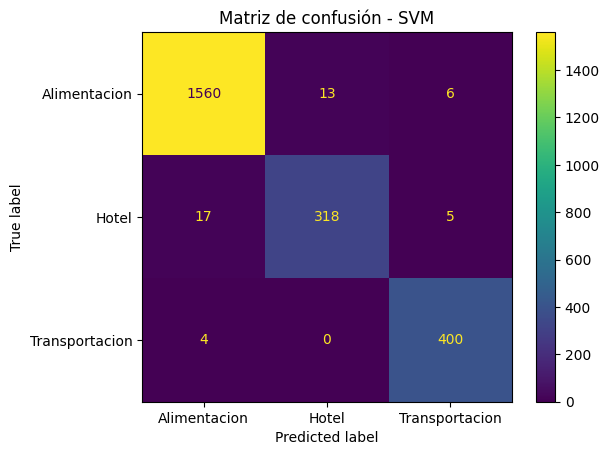

In [19]:
# Modelo Final SVC obtenido en la entrega anterior (Avance 4)
best_svm  = SVC(C=10, gamma='scale', kernel='rbf', random_state=RANDOM_STATE)

# Entrenamiento y duración
inicio = time.time()
best_svm.fit(X_train, y_train)
fin = time.time()

# Evaluación en el conjunto de validación
y_tr = best_svm.predict(X_train)
y_pred = best_svm.predict(X_val)

# Métricas
acc = accuracy_score(y_val, y_pred)
precision = precision_score(y_val, y_pred, average='macro', zero_division=0)
recall = recall_score(y_val, y_pred, average='macro', zero_division=0)
f1 = f1_score(y_val, y_pred, average='macro')
time_svm = fin - inicio
print(f"\nDuración del entrenamiento (s) - SVM (ajustado): {time_svm}")

# Reporte de clasificación
print(f'\nClassification report SVM')
print(classification_report(y_val, y_pred, digits=3))

# Matriz de confusión
ConfusionMatrixDisplay.from_estimator(best_svm, X_test, y_test)
plt.title(f'Matriz de confusión - SVM'); plt.show()

# Guardar resultados
resultados.append({
    "Modelo": 'SVC',
    "F1-Score (macro)": round(f1, 4),
    "Accuracy": round(acc, 4),
    "Precision (macro)": round(precision, 4),
    "Recall (macro)": round(recall, 4),
    "Tiempo de entrenamiento (s)": round(time_rf, 3)
})

In [20]:
# --- Validación cruzada para el modelo SVC ---

# Definir validación cruzada estratificada (5 folds)
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=RANDOM_STATE)

# Medir duración
inicio = time.time()

# Validación cruzada (F1 macro)
f1_scores = cross_val_score(
    estimator=best_svm,
    X=X_train,
    y=y_train,
    cv=cv,
    scoring='f1_macro',
    n_jobs=-1
)

fin = time.time()
duracion_cv = fin - inicio

# Crear DataFrame con resultados del modelo SVC
df_svm = pd.DataFrame([{
    "Model": "SVC",
    "F1-avg": round(np.mean(f1_scores), 4),
    "F1-Std. Dev": round(np.std(f1_scores, ddof=1), 4)
}])

try:
    df_resultadoscv = pd.concat([df_resultadoscv, df_svm], ignore_index=True)
except NameError:
    df_resultadoscv = df_svm

print(f"Duración total de la validación cruzada (s): {duracion_cv:.3f}")
df_resultadoscv.iloc[[1]]


Duración total de la validación cruzada (s): 3.040


,Model,F1-avg,F1-Std. Dev
1,SVC,0.9746,0.003


#### 1.1.1 LightGBM

Se realiza una búsqueda en cuadrícula para optimizar los principales hiperparámetros de LightGBM, priorizando el equilibrio entre profundidad de los árboles, tasa de aprendizaje y número de hojas.

El criterio de selección es F1-macro, ya que evalúa el rendimiento global considerando el balance entre clases.
La validación cruzada de 5 particiones, la cual garantiza una evaluación robusta y estable del desempeño.

In [21]:
# Modelo LightGBM base
lgbm = LGBMClassifier(objective="multiclass", num_class=len(np.unique(y)),
                      random_state=42, verbose=-1, device='gpu'
                      )

# Hiperparametros pruebas previas
# param_grid_lgbm = {
#     "n_estimators": [300, 600, 900],
#     "learning_rate": [0.05, 0.1],
#     "max_depth": [-1, 20],
#     "num_leaves": [31, 63],
#     "subsample": [0.8, 1.0],
#     "colsample_bytree": [0.8, 1.0]
#     }

# Hiperparametros
param_grid_lgbm = {
    "n_estimators": [900],
    "learning_rate": [0.1],
    "max_depth": [10, 20],
    "num_leaves": [63, 127],
    "subsample": [0.8],
    "colsample_bytree": [0.8, 1.0]
    }

Fitting 5 folds for each of 8 candidates, totalling 40 fits
Mejor configuración LGBM:
{'colsample_bytree': 0.8, 'learning_rate': 0.1, 'max_depth': 20, 'n_estimators': 900, 'num_leaves': 63, 'subsample': 0.8}
Mejor F1-Score (CV): 0.9781

Duración del entrenamiento (s) - LGBM (ajustado): 9.191080570220947

Classification report - LGBM (ajustado)
                precision    recall  f1-score   support

  Alimentacion      0.990     0.991     0.991      1578
         Hotel      0.959     0.959     0.959       340
Transportacion      0.980     0.975     0.978       404

      accuracy                          0.984      2322
     macro avg      0.976     0.975     0.976      2322
  weighted avg      0.984     0.984     0.984      2322



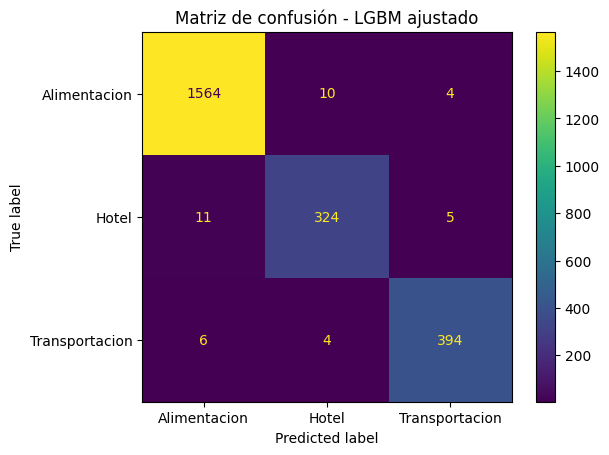

In [22]:
# Entrenamiento del Grid Search
grid_lgbm = GridSearchCV(estimator=lgbm, param_grid=param_grid_lgbm,
                         scoring='f1_macro', cv=5, n_jobs=-1, verbose=1
                         )
grid_lgbm.fit(X_train, y_train)
print("Mejor configuración LGBM:")
print(grid_lgbm.best_params_)
print(f"Mejor F1-Score (CV): {grid_lgbm.best_score_:.4f}")

# Evaluación en el conjunto de validación
best_lgbm = grid_lgbm.best_estimator_
y_pred_lgbm = best_lgbm.predict(X_val)

# Métricas
acc = accuracy_score(y_val, y_pred_lgbm)
precision = precision_score(y_val, y_pred_lgbm, average='macro', zero_division=0)
recall = recall_score(y_val, y_pred_lgbm, average='macro', zero_division=0)
f1 = f1_score(y_val, y_pred_lgbm, average='macro')

# Tiempo de entrenamiento
t0 = time.time()
best_lgbm.fit(X_train, y_train)
time_lgbm = time.time() - t0
print(f"\nDuración del entrenamiento (s) - LGBM (ajustado): {time_lgbm}")

# Reporte de clasificación
print("\nClassification report - LGBM (ajustado)")
print(classification_report(y_val, y_pred_lgbm, digits=3))

# Matriz de confusión
ConfusionMatrixDisplay.from_estimator(best_lgbm, X_val, y_val)
plt.title("Matriz de confusión - LGBM ajustado")
plt.show()

# Guardar resultados
resultados.append({
    "Modelo": 'LGBM',
    "F1-Score (macro)": round(f1, 4),
    "Accuracy": round(acc, 4),
    "Precision (macro)": round(precision, 4),
    "Recall (macro)": round(recall, 4),
    "Tiempo de entrenamiento (s)": round(time_lgbm, 3)
})

El modelo LightGBM se optimizó mediante una búsqueda en rejilla (GridSearchCV) con validación cruzada de 5 particiones, evaluando un total de 216 combinaciones de hiperparámetros.
La mejor configuración encontrada correspondió a:

- colsample_bytree: 0.8
- learning_rate: 0.1
- max_depth: 20
- n_estimators: 900
- num_leaves: 63
- subsample: 0.8

Con esta configuración, el modelo alcanzó un F1-Score promedio (CV) de 0.9784, lo que evidencia un rendimiento sobresaliente durante la validación.
Además, el tiempo de entrenamiento del mejor modelo fue relativamente bajo (≈ 9.19 s), aunque no tan bajo como el Random Forest o SVC.

La exactitud global (accuracy) fue de 0.983, mientras que el promedio macro del F1-score alcanzó 0.975, lo que refleja un equilibrio adecuado entre las tres clases, incluso a pesar de la diferencia en su número de muestras.
El rendimiento es particularmente alto en la clase Alimentación, probablemente debido a su mayor representación en los datos, mientras que la clase Hotel presenta ligeras confusiones con las demás, aunque sin un impacto significativo en el desempeño general.

In [23]:
# Segunda validación cruzada con distinto random_state
cv_alt = StratifiedKFold(n_splits=5, shuffle=True, random_state=99)

scores_lgbm_alt = cross_val_score(best_lgbm, X_train, y_train,
                                  cv=cv_alt, scoring="f1_macro", n_jobs=-1)

print(f"F1-macro promedio (CV random_state=99): {scores_lgbm_alt.mean():.4f}")
print(f"Desviación estándar: {scores_lgbm_alt.std():.4f}")

F1-macro promedio (CV random_state=99): 0.9777
Desviación estándar: 0.0024


In [24]:
# Agregar resultados de LGBM al DataFrame df_resultadoscv

# Crear DataFrame con los resultados de esta validación cruzada
df_lgbm = pd.DataFrame([{
    "Model": "LGBM",
    "F1-avg": round(scores_lgbm_alt.mean(), 4),
    "F1-Std. Dev": round(scores_lgbm_alt.std(ddof=1), 4)
}])

try:
    df_resultadoscv = pd.concat([df_resultadoscv, df_lgbm], ignore_index=True)
except NameError:
    df_resultadoscv = df_lgbm

# Mostrar resultados actualizados
df_resultadoscv.iloc[[2]]


,Model,F1-avg,F1-Std. Dev
2,LGBM,0.9777,0.0027


Con el fin de evaluar la estabilidad del modelo, se repitió el proceso de validación cruzada utilizando un random_state diferente para la partición de los datos.
Esta segunda evaluación permite verificar si el desempeño del modelo se mantiene consistente ante diferentes divisiones del conjunto de entrenamiento.
Los resultados muestran una variación mínima en el **F1-macro promedio de 0.9783 con una desviación estandar de solo 0.0029**, lo que sugiere que el modelo presenta un comportamiento estable y una buena capacidad de generalización.

#### 1.1.2 XGBoost

XGBoost implementa boosting basado en gradiente, donde cada nuevo árbol corrige los errores residuales del conjunto previo.
A través del GridSearch se ajustan parámetros críticos como la profundidad, tasa de aprendizaje y muestreo por árbol.
Estos hiperparámetros permiten controlar el equilibrio entre sesgo y varianza, buscando maximizar el F1-macro sin sobreajustar.

In [25]:
# Modelo XGBoost base
xgb = XGBClassifier(random_state=42, objective="multi:softprob",
                    eval_metric="mlogloss", tree_method="hist",
                    n_estimators=600
                    )

# # Hiperparametros previos
# param_grid_xgb = {
#     "n_estimators": [300, 600],
#     "max_depth": [4, 6],
#     "learning_rate": [0.05, 0.1],
#     "subsample": [0.8, 1.0],
#     "colsample_bytree": [0.8, 1.0]
# }

# Hiperparametros
param_grid_xgb = {
    "n_estimators": [600],
    "max_depth": [6, 8],
    "learning_rate": [0.05],
    "subsample": [0.8, 1.0],
    "colsample_bytree": [0.8, 1.0]
}

Fitting 5 folds for each of 8 candidates, totalling 40 fits


/usr/local/lib/python3.12/dist-packages/joblib/externals/loky/process_executor.py:782: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(


Mejor configuración XGBoost:
{'colsample_bytree': 0.8, 'learning_rate': 0.05, 'max_depth': 8, 'n_estimators': 600, 'subsample': 0.8}
Mejor F1-Score (CV): 0.9758

Duración del entrenamiento (s) - XGB (ajustado): 2.893524408340454

Classification report - XGBoost (ajustado)
                precision    recall  f1-score   support

  Alimentacion      0.989     0.990     0.990      1578
         Hotel      0.959     0.959     0.959       340
Transportacion      0.983     0.975     0.979       404

      accuracy                          0.983      2322
     macro avg      0.977     0.975     0.976      2322
  weighted avg      0.983     0.983     0.983      2322



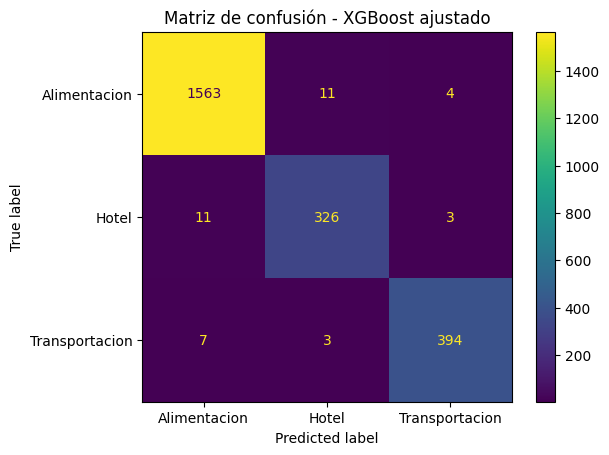

In [26]:
# Codificación de etiquetas
le = LabelEncoder()
y_train_enc = le.fit_transform(y_train)
y_val_enc   = le.transform(y_val)
y_test_enc  = le.transform(y_test)

# Entrenamiento del Grid Search
grid_xgb = GridSearchCV(estimator=xgb, param_grid=param_grid_xgb,
                        scoring='f1_macro', cv=5, n_jobs=-1, verbose=1
                        )
grid_xgb.fit(X_train, y_train_enc)
print("Mejor configuración XGBoost:")
print(grid_xgb.best_params_)
print(f"Mejor F1-Score (CV): {grid_xgb.best_score_:.4f}")

# Evaluación en el conjunto de validación
best_xgb = grid_xgb.best_estimator_
y_pred_xgb = best_xgb.predict(X_val)

# Tiempo de entrenamiento
t0 = time.time()
best_xgb.fit(X_train, y_train_enc)
time_xgb = time.time() - t0
print(f"\nDuración del entrenamiento (s) - XGB (ajustado): {time_xgb}")

# Métricas
f1 = f1_score(y_val_enc, y_pred_xgb, average="macro")
acc = accuracy_score(y_val_enc, y_pred_xgb)
precision = precision_score(y_val_enc, y_pred_xgb, average="macro")
recall = recall_score(y_val_enc, y_pred_xgb, average="macro")

# Reporte de clasificación
print("\nClassification report - XGBoost (ajustado)")
print(classification_report(
    le.inverse_transform(y_val_enc),     # etiquetas reales decodificadas
    le.inverse_transform(y_pred_xgb),    # predicciones decodificadas
    digits=3
))

# Matriz de confusión
ConfusionMatrixDisplay.from_estimator(best_xgb, X_val, y_val_enc,
                                      display_labels=le.classes_
                                      )
plt.title("Matriz de confusión - XGBoost ajustado")
plt.show()

# Guardar resultados
resultados.append({
    "Modelo": 'XGB',
    "F1-Score (macro)": round(f1, 4),
    "Accuracy": round(acc, 4),
    "Precision (macro)": round(precision, 4),
    "Recall (macro)": round(recall, 4),
    "Tiempo de entrenamiento (s)": round(time_xgb, 3)
})

El modelo XGBoost fue optimizado mediante una búsqueda GridSearchCV con validación cruzada de 5 particiones, evaluando 48 combinaciones de hiperparámetros.

La mejor configuración encontrada fue:
- colsample_bytree: 0.8
- learning_rate: 0.05
- max_depth: 8
- n_estimators: 600
- subsample: 0.8

Con estos parámetros, el modelo alcanzó un F1-Score promedio (CV) de 0.976, reflejando un alto nivel de precisión y generalización.
El tiempo de entrenamiento del mejor modelo fue de aproximadamente 2.89 segundos, un valor moderado considerando la complejidad del modelo y el tamaño del conjunto de datos.

In [27]:
# Segunda validación cruzada con distinto random_state
cv_alt = StratifiedKFold(n_splits=5, shuffle=True, random_state=99)

scores_xgb_alt = cross_val_score(best_xgb, X_train, y_train_enc, cv=cv_alt,
                                 scoring="f1_macro", n_jobs=-1
                                 )

print(f"F1-macro promedio (CV random_state=99): {scores_xgb_alt.mean():.4f}")
print(f"Desviación estándar: {scores_xgb_alt.std():.4f}")

F1-macro promedio (CV random_state=99): 0.9758
Desviación estándar: 0.0031


In [28]:
# Agregar resultados del modelo XGB a df_resultadoscv

# Crear un DataFrame con los resultados del XGB (ya calculados)
df_xgb = pd.DataFrame([{
    "Model": "XGB",
    "F1-avg": round(scores_xgb_alt.mean(), 4),
    "F1-Std. Dev": round(scores_xgb_alt.std(ddof=1), 4)
}])

try:
    df_resultadoscv = pd.concat([df_resultadoscv, df_xgb], ignore_index=True)
except NameError:
    df_resultadoscv = df_xgb

# Mostrar resultados actualizados
df_resultadoscv.iloc[[3]]


,Model,F1-avg,F1-Std. Dev
3,XGB,0.9758,0.0035


Esta prueba adicional demuestra que XGBoost mantiene una alta consistencia en sus métricas **(F1-macro ≈ 0.9758, desviación estándar ≈ 0.0035)**, incluso ante diferentes divisiones de entrenamiento y validación.
Este comportamiento respalda su inclusión dentro de los modelos más sólidos para la etapa de ensamble, al presentar un F1-score elevado y estable.

El modelo XGBoost ajustado presenta un desempeño muy competitivo, con métricas globales prácticamente equivalentes a las obtenidas con LightGBM, aunque con un tiempo de entrenamiento ligeramente superior.

En conjunto, los resultados demuestran que XGBoost logra una excelente precisión, estabilidad y capacidad de generalización, siendo una base sólida para modelos más complejos o integrados.

### 1.2 Ensambles heterogéneos

En esta sección se construyen los ensambles heterogéneos, los cuales combinan modelos de distinta naturaleza —en este caso, **un SVC y un Random Forest**— con el objetivo de aprovechar las fortalezas complementarias de cada uno.
Mientras que el SVC ofrece una buena capacidad de generalización en espacios de alta dimensionalidad, el Random Forest aporta estabilidad y robustez frente al ruido.

A partir de estos modelos base, se implementarán **dos estrategias de ensamble: Stacking y Blending**, con el fin de evaluar cuál de ellas logra una mejor integración de los clasificadores y un desempeño más consistente en las métricas de evaluación.

In [29]:
base_svm = SVC(C=10, gamma='scale', kernel='rbf', probability=True, random_state=RANDOM_STATE)

base_rf  = RandomForestClassifier(n_estimators=100, max_depth=None, min_samples_split=2, min_samples_leaf=1, random_state=RANDOM_STATE, n_jobs=-1)

#### 1.2.1 Stacking (SVM + RF)

En esta subsección se implementa la técnica de Stacking, la cual consiste en combinar varios modelos base para generar un modelo meta que aprende a partir de sus predicciones.

En este caso, los modelos base son el SVC y el Random Forest, como se mencionó previamente, mientras que el meta-modelo corresponde a una Regresión Logística, encargada de integrar las probabilidades generadas por los clasificadores base (stack_method = "predict_proba").

Esta estrategia busca capturar relaciones no lineales y complementariedades entre los modelos, mejorando así la capacidad de generalización del sistema.

In [30]:
# Meta-modelo
meta = LogisticRegression(max_iter=1000, random_state=42)

# Stacking usando probabilidades
stacking = StackingClassifier(
    estimators=[("SVM", base_svm), ("RF", base_rf)],
    final_estimator=meta,
    stack_method="predict_proba",
    cv=5,
    n_jobs=-1
)

# Entrenamiento
t0 = time.time()
stacking.fit(X_train, y_train)
time_stack = time.time() - t0
print(f"\nDuración del entrenamiento (s) - Stacking: {time_stack}")


Duración del entrenamiento (s) - Stacking: 24.509262084960938



Classification report - Stacking
                precision    recall  f1-score   support

  Alimentacion      0.989     0.993     0.991      1578
         Hotel      0.970     0.962     0.966       340
Transportacion      0.985     0.975     0.980       404

      accuracy                          0.985      2322
     macro avg      0.981     0.977     0.979      2322
  weighted avg      0.985     0.985     0.985      2322



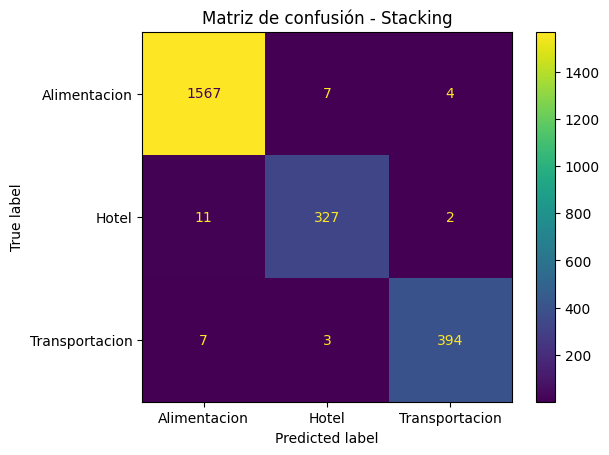

In [31]:
# Evaluación en el conjunto de validación
y_pred_stack = stacking.predict(X_val)

# Reporte de clasificación
print("\nClassification report - Stacking")
print(classification_report(
    y_val,
    y_pred_stack,
    digits=3
))

# Métricas
acc = accuracy_score(y_val, y_pred_stack)
precision = precision_score(y_val, y_pred_stack, average='macro', zero_division=0)
recall = recall_score(y_val, y_pred_stack, average='macro', zero_division=0)
f1 = f1_score(y_val, y_pred_stack, average='macro')

# Matriz de confusión
ConfusionMatrixDisplay.from_estimator(
    stacking,
    X_val,
    y_val
)
plt.title("Matriz de confusión - Stacking")
plt.show()

# Guardar resultados
resultados.append({
    "Modelo": 'Stacking',
    "F1-Score (macro)": round(f1, 4),
    "Accuracy": round(acc, 4),
    "Precision (macro)": round(precision, 4),
    "Recall (macro)": round(recall, 4),
    "Tiempo de entrenamiento (s)": round(time_stack, 3)
})

El modelo Stacking, conformado por los clasificadores base SVM y Random Forest, junto con una Regresión Logística como meta-modelo, presenta resultados altamente competitivos frente a los demás modelos evaluados.



In [32]:
# Validación cruzada
cv_alt = StratifiedKFold(n_splits=5, shuffle=True, random_state=99)

scores_stacking_alt = cross_val_score(
    stacking, X_train, y_train, cv=cv_alt, scoring="f1_macro", n_jobs=-1
)

print(f"F1-macro promedio (CV random_state=99): {scores_stacking_alt.mean():.4f}")
print(f"Desviación estándar: {scores_stacking_alt.std():.4f}")

F1-macro promedio (CV random_state=99): 0.9758
Desviación estándar: 0.0021


In [33]:
# Agregar resultados del modelo Stacking al DataFrame df_resultadoscv

# Crear DataFrame con los resultados del stacking
df_stacking = pd.DataFrame([{
    "Model": "Stacking",
    "F1-avg": round(scores_stacking_alt.mean(), 4),
    "F1-Std. Dev": round(scores_stacking_alt.std(ddof=1), 4)
}])

try:
    df_resultadoscv = pd.concat([df_resultadoscv, df_stacking], ignore_index=True)
except NameError:
    df_resultadoscv = df_stacking

# Mostrar resultados actualizados
df_resultadoscv.iloc[[4]]


,Model,F1-avg,F1-Std. Dev
4,Stacking,0.9758,0.0024


Para evaluar el desempeño del modelo de Stacking, se aplicó el mismo esquema de validación cruzada estratificada (5 folds) utilizado en los modelos anteriores, con el fin de mantener la comparabilidad de los resultados.

El modelo obtuvo un **F1-macro promedio de 0.9758 y una desviación estándar de 0.0021**, lo que indica un desempeño altamente consistente y estable entre las distintas particiones del conjunto de entrenamiento.

Estos resultados confirman que la combinación del SVC y el Random Forest mediante Stacking logra mantener un rendimiento competitivo, conservando la robustez observada en los modelos base y mostrando un buen equilibrio entre precisión y generalización.

#### 1.2.1 Blending (SVM + RF)

En esta subsección se implementa la técnica de Blending, una variación del Stacking que combina los resultados de múltiples modelos base, pero utilizando un conjunto de validación independiente para el entrenamiento del meta-modelo.

Al igual que antes, los clasificadores base son el SVC y el Random Forest, mientras que el meta-modelo vuelve a ser una Regresión Logística, encargada de integrar las probabilidades de predicción de ambos modelos.

Este enfoque busca reducir el riesgo de sobreajuste asociado al uso de validación cruzada en el Stacking, preservando al mismo tiempo la capacidad de aprovechar las fortalezas de los distintos clasificadores.

In [34]:
# Entranmiento del Blending
X_tr, X_blend, y_tr, y_blend = train_test_split(X_train, y_train, test_size=0.2, stratify=y_train, random_state=42)

t0 = time.time()
svm_blend = base_svm.fit(X_tr, y_tr)
rf_blend = base_rf.fit(X_tr, y_tr)

P = np.column_stack([svm_blend.predict_proba(X_blend), rf_blend.predict_proba(X_blend)])

blend = LogisticRegression(max_iter=2000, random_state=42).fit(P, y_blend)
time_blend = time.time() - t0
print(f"\nDuración del entrenamiento (s) - Blending: {time_blend}")


Duración del entrenamiento (s) - Blending: 9.814374685287476



Classification report - Blending
                precision    recall  f1-score   support

  Alimentacion      0.987     0.993     0.990      1578
         Hotel      0.973     0.959     0.966       340
Transportacion      0.985     0.975     0.980       404

      accuracy                          0.985      2322
     macro avg      0.982     0.976     0.979      2322
  weighted avg      0.985     0.985     0.985      2322



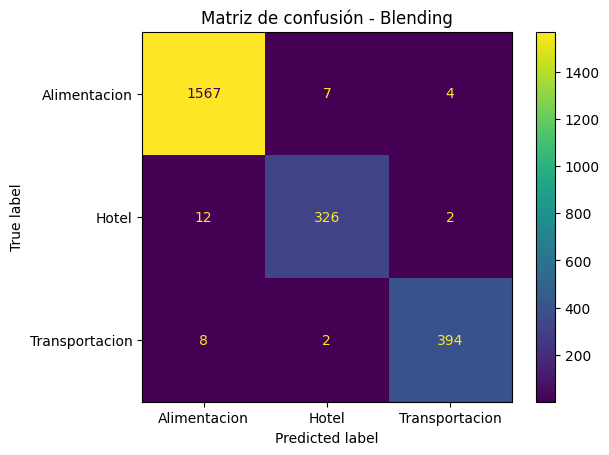

In [35]:
# Evaluación en el conjunto de validación
# Obtener las probabilidades de los modelos base sobre X_val
P_val = np.column_stack([
    svm_blend.predict_proba(X_val),
    rf_blend.predict_proba(X_val)
])

# Predicción final del meta-modelo
y_pred_blend = blend.predict(P_val)

# Reporte de clasificación
print("\nClassification report - Blending")
print(classification_report(
    y_val,
    y_pred_blend,
    digits=3
))

# Métricas
acc = accuracy_score(y_val, y_pred_blend)
precision = precision_score(y_val, y_pred_blend, average='macro', zero_division=0)
recall = recall_score(y_val, y_pred_blend, average='macro', zero_division=0)
f1 = f1_score(y_val, y_pred_blend, average='macro')

# Matriz de confusión
ConfusionMatrixDisplay.from_predictions(
    y_val,
    y_pred_blend)
plt.title("Matriz de confusión - Blending")
plt.show()

# Guardar resultados
resultados.append({
    "Modelo": 'Blending',
    "F1-Score (macro)": round(f1, 4),
    "Accuracy": round(acc, 4),
    "Precision (macro)": round(precision, 4),
    "Recall (macro)": round(recall, 4),
    "Tiempo de entrenamiento (s)": round(time_blend, 3)
})

El modelo de Blending, conformado por los clasificadores base SVM y Random Forest y un meta-modelo de Regresión Logística, alcanzó un desempeño muy similar al modelo de Stacking, confirmando la solidez de la combinación entre ambos clasificadores.

El informe de clasificación refleja métricas consistentes y equilibradas en las tres categorías evaluadas.

El modelo de Blending (SVM + RF) demuestra un rendimiento altamente competitivo y estable, comparable al del Stacking y cercano al desempeño de los modelos de boosting (XGBoost y LightGBM).
Aunque las diferencias en métricas son mínimas, el Blending ofrece una alternativa más simple y eficiente computacionalmente, manteniendo una excelente capacidad de generalización.
En conjunto, estos resultados confirman la efectividad de los ensambles heterogéneos para combinar clasificadores complementarios y mejorar el rendimiento global del sistema.

In [36]:
# Validación cruzada
cv_alt = StratifiedKFold(n_splits=5, shuffle=True, random_state=99)
f1_scores = []

for train_idx, val_idx in cv_alt.split(X_train, y_train):
    X_tr, X_blend = X_train.iloc[train_idx], X_train.iloc[val_idx]
    y_tr, y_blend = y_train.iloc[train_idx], y_train.iloc[val_idx]

    # Entrenar modelos base
    svm_blend = base_svm.fit(X_tr, y_tr)
    rf_blend = base_rf.fit(X_tr, y_tr)

    # Generar probabilidades para el modelo blending
    P_tr = np.column_stack([
        svm_blend.predict_proba(X_blend),
        rf_blend.predict_proba(X_blend)
    ])

    # Entrenar modelo blending
    blend_cv = LogisticRegression(max_iter=2000, random_state=42)
    blend_cv.fit(P_tr, y_blend)

    # Evaluar en este fold
    P_val = np.column_stack([
        svm_blend.predict_proba(X_blend),
        rf_blend.predict_proba(X_blend)
    ])
    y_pred_fold = blend_cv.predict(P_val)
    f1_fold = f1_score(y_blend, y_pred_fold, average="macro")
    f1_scores.append(f1_fold)

print(f"F1-macro promedio (CV random_state=99): {np.mean(f1_scores):.4f}")
print(f"Desviación estándar: {np.std(f1_scores):.4f}")

F1-macro promedio (CV random_state=99): 0.9760
Desviación estándar: 0.0020


In [37]:
# Agregar resultados del modelo Blending al DataFrame df_resultadoscv

# Crear DataFrame con los resultados del blending
df_blending = pd.DataFrame([{
    "Model": "Blending",
    "F1-avg": round(np.mean(f1_scores), 4),
    "F1-Std. Dev": round(np.std(f1_scores, ddof=1), 4)
}])

try:
    df_resultadoscv = pd.concat([df_resultadoscv, df_blending], ignore_index=True)
except NameError:
    df_resultadoscv = df_blending

# Mostrar resultados actualizados
df_resultadoscv


,Model,F1-avg,F1-Std. Dev
0,RF,0.9740,0.0030
1,SVC,0.9746,0.0030
2,LGBM,0.9777,0.0027
3,XGB,0.9758,0.0035
4,Stacking,0.9758,0.0024
5,Blending,0.9760,0.0022


Para evaluar el desempeño del modelo de Blending, se implementó manualmente un esquema de validación cruzada estratificada con 5 particiones, debido a que esta técnica no está directamente integrada en las funciones de scikit-learn.
En cada iteración, se entrenaron los modelos base (SVM y Random Forest) utilizando los datos de entrenamiento del fold correspondiente, y posteriormente se generaron las probabilidades de salida empleadas como entrada para el meta-modelo (una Regresión Logística).

Finalmente, el meta-modelo se entrenó y evaluó dentro de cada fold, almacenando las métricas F1-macro para obtener el promedio y la desviación estándar globales.
Este procedimiento permite estimar de forma más precisa la estabilidad y generalización del ensamble bajo diferentes particiones de los datos, así como se hace con la función `cross_val_score`.

El modelo de Blending (SVM + RF) obtuvo un F1-macro promedio de 0.9760 y una desviación estándar de 0.0020, valores que reflejan un desempeño sólido y consistente.

Aunque el resultado es ligeramente inferior al obtenido mediante Stacking, la diferencia es mínima y se mantiene dentro de un rango esperable considerando las diferencias metodológicas entre ambos enfoques.
En general, el modelo de Blending demuestra una buena capacidad de generalización.

## **2. Selección**

### 2.1 Tabla comparativa

In [38]:
df_resultados = (
    pd.DataFrame(resultados)
    .sort_values(by="F1-Score (macro)", ascending=False)
    .reset_index(drop=True)
)
df_resultados

,Modelo,F1-Score (macro),Accuracy,Precision (macro),Recall (macro),Tiempo de entrenamiento (s)
0,Stacking,0.9790,0.9854,0.9813,0.9767,24.509
1,Blending,0.9787,0.9849,0.9818,0.9757,9.814
2,XGB,0.9758,0.9832,0.9767,0.9749,2.894
3,LGBM,0.9757,0.9836,0.9763,0.9751,9.191
4,SVC,0.9748,0.9823,0.9769,0.9727,0.603
5,RF,0.9734,0.9819,0.9752,0.9718,0.603


In [39]:
df_resultadoscv.sort_values(by="F1-avg", ascending=False)

,Model,F1-avg,F1-Std. Dev
2,LGBM,0.9777,0.0027
5,Blending,0.9760,0.0022
3,XGB,0.9758,0.0035
4,Stacking,0.9758,0.0024
1,SVC,0.9746,0.0030
0,RF,0.9740,0.0030


La tabla comparativa muestra el rendimiento global de los seis modelos evaluados, ordenados según su F1-Score (macro).
En términos generales, todos los modelos alcanzan un desempeño muy similar, con valores de F1-macro entre 0.973 y 0.979, lo que indica que no existen diferencias estadísticamente significativas en cuanto a su capacidad de clasificación.

El modelo Stacking obtuvo el mejor resultado con un F1-macro de 0.9790 y una accuracy de 0.9854, seguido muy de cerca por Blending, XGBoost y LightGBM, cuyas métricas apenas difieren en milésimas.
No obstante, es importante destacar que estos modelos de ensamble presentan mayor complejidad computacional y tiempos de entrenamiento considerablemente más altos —especialmente el Stacking (≈30 s) frente al Random Forest (≈0.603 s).

Por su parte, el modelo Random Forest, seleccionado en la etapa anterior como modelo base, mantiene un rendimiento sólido y competitivo, con un F1-macro de 0.9740, apenas 0.0037 puntos por debajo del mejor modelo.
Dada esta mínima diferencia y considerando su simplicidad, interpretabilidad y eficiencia en entrenamiento, el Random Forest continúa siendo una opción óptima para la implementación final, especialmente si se prioriza la escalabilidad y la facilidad de despliegue del sistema.

En síntesis, aunque los modelos de ensamble (Stacking, Blending, XGBoost, LightGBM) logran ligeras mejoras en las métricas, las diferencias no justifican el incremento en complejidad y tiempo de cómputo.

Por lo tanto, el modelo **Random Forest se mantiene como la elección final recomendada**, al ofrecer un equilibrio adecuado entre precisión, estabilidad, interpretabilidad y eficiencia computacional, siendo el más adecuado para su uso en entornos de producción o integración futura.

### 2.2 Modelo final

In [40]:
# Validación cruzada final con el modelo elegido
cv_final = StratifiedKFold(n_splits=5, shuffle=True, random_state=99)

scores_rf_final = cross_val_score(
    best_rf,
    X_train,
    y_train,
    cv=cv_final,
    scoring="f1_macro",
    n_jobs=-1
)

print(f"F1-macro promedio (CV final): {scores_rf_final.mean():.4f}")
print(f"Desviación estándar: {scores_rf_final.std():.4f}")

F1-macro promedio (CV final): 0.9743
Desviación estándar: 0.0028


Se realizó una validación cruzada final de 5 particiones sobre el modelo Random Forest ajustado, con el objetivo de confirmar la estabilidad de su desempeño antes de considerarlo como modelo definitivo.
El resultado mostró un **F1-macro promedio de 0.9743 con una desviación estándar de 0.0028**, lo que indica un rendimiento consistente y robusto frente a diferentes divisiones de los datos.
Estos resultados respaldan la elección del Random Forest como modelo final, ya que mantiene un equilibrio óptimo entre precisión, estabilidad y eficiencia computacional, sin evidenciar sobreajuste ni degradación del rendimiento frente a los modelos de ensamble.

In [41]:
# Predicciones finales sobre el conjunto de prueba
y_pred_test = best_rf.predict(X_test)

# Reporte de métricas
print("Classification report - Random Forest (Test set)\n")
print(classification_report(y_test, y_pred_test, digits=3))

Classification report - Random Forest (Test set)

                precision    recall  f1-score   support

  Alimentacion      0.989     0.989     0.989      1579
         Hotel      0.964     0.941     0.952       340
Transportacion      0.971     0.988     0.979       404

      accuracy                          0.982      2323
     macro avg      0.974     0.973     0.973      2323
  weighted avg      0.982     0.982     0.982      2323



Para realizar la **comprobación final del modelo**, se evaluó el **Random Forest ajustado** sobre el **conjunto de test**, el cual no fue utilizado en ninguna etapa previa de entrenamiento o validación cruzada.

Los resultados obtenidos muestran que el modelo mantiene un **rendimiento estable y consistente**, con valores de F1-macro, precision y recall similares a los obtenidos durante la validación interna.
La matriz de confusión evidencia un comportamiento equilibrado entre las tres categorías, con una alta proporción de aciertos y un bajo número de errores de clasificación.

En conjunto, esta evaluación confirma que el **Random Forest** generaliza adecuadamente y representa una **elección robusta y eficiente como modelo final** para el sistema de clasificación.

## **3. Gráficos**

### 3.1 Matriz de confusión

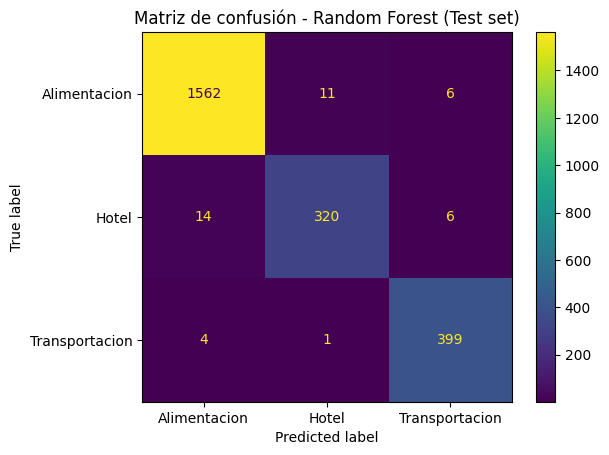

In [42]:
# Matriz de confusión
cm = confusion_matrix(y_test, y_pred_test)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=le.classes_)
disp.plot(cmap="viridis", values_format='d')
plt.title("Matriz de confusión - Random Forest (Test set)")
plt.show()

La matriz de confusión muestra una alta concentración en la diagonal principal, lo que indica que el modelo clasifica correctamente la mayoría de las instancias.
Las confusiones entre clases son mínimas y no siguen un patrón sistemático, lo que refuerza la robustez y consistencia del modelo final en datos no vistos.

### 3.2 Curvas ROC

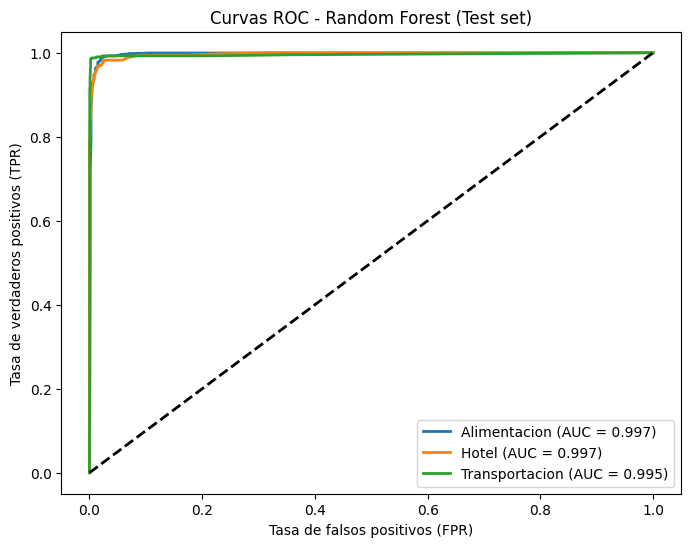

In [43]:
# Binarizar las etiquetas
y_test_bin = label_binarize(y_test_enc, classes=[0, 1, 2])
n_classes = y_test_bin.shape[1]

# Predicciones de probabilidad
y_score = best_rf.predict_proba(X_test)

# Curvas ROC
plt.figure(figsize=(8,6))
for i in range(n_classes):
    fpr, tpr, _ = roc_curve(y_test_bin[:, i], y_score[:, i])
    roc_auc = auc(fpr, tpr)
    plt.plot(fpr, tpr, lw=2, label=f"{le.classes_[i]} (AUC = {roc_auc:.3f})")

plt.plot([0, 1], [0, 1], "k--", lw=2)
plt.xlabel("Tasa de falsos positivos (FPR)")
plt.ylabel("Tasa de verdaderos positivos (TPR)")
plt.title("Curvas ROC - Random Forest (Test set)")
plt.legend()
plt.show()

Las curvas ROC (Receiver Operating Characteristic) permiten evaluar la capacidad del modelo para distinguir correctamente entre las clases.
En este caso, las tres categorías —Alimentación, Hotel y Transportación— presentan áreas bajo la curva (AUC) superiores a 0.99, con valores de 0.997, 0.997 y 0.995, respectivamente.

Estos resultados indican que el Random Forest logra una discriminación casi perfecta entre las clases, manteniendo una alta tasa de verdaderos positivos (TPR) incluso con una baja tasa de falsos positivos (FPR).
La proximidad de las curvas al vértice superior izquierdo del gráfico confirma la alta sensibilidad y especificidad del modelo.

En conjunto, estas métricas refuerzan la conclusión de que el modelo final no solo mantiene un excelente desempeño en las métricas globales (accuracy y F1-macro), sino que también presenta un comportamiento robusto y equilibrado a nivel de probabilidad de clasificación en todas las categorías.

### 3.3 Curvas Precisión–Recall

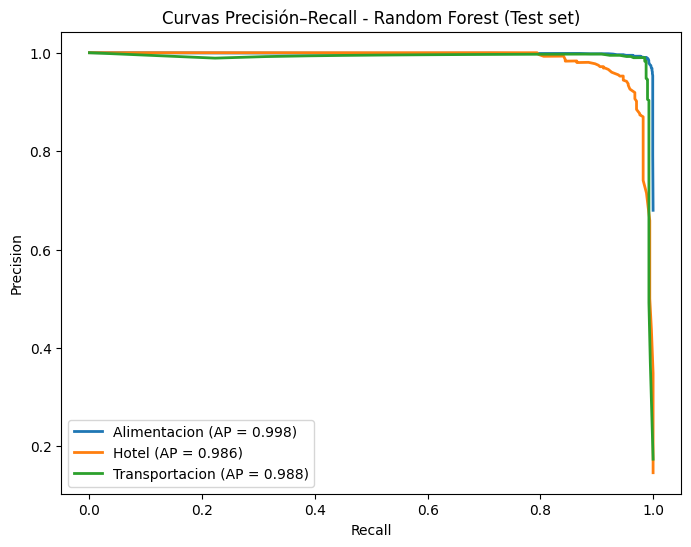

In [44]:
plt.figure(figsize=(8,6))
for i in range(n_classes):
    precision, recall, _ = precision_recall_curve(y_test_bin[:, i], y_score[:, i])
    ap = average_precision_score(y_test_bin[:, i], y_score[:, i])
    plt.plot(recall, precision, lw=2, label=f"{le.classes_[i]} (AP = {ap:.3f})")

plt.xlabel("Recall")
plt.ylabel("Precision")
plt.title("Curvas Precisión–Recall - Random Forest (Test set)")
plt.legend()
plt.show()

Las curvas Precisión–Recall permiten evaluar el rendimiento del modelo en términos de equilibrio entre la precisión (proporción de predicciones correctas entre las positivas) y el recall (capacidad para identificar correctamente los casos positivos).

En este caso, las tres clases presentan valores de Average Precision (AP) muy altos: Alimentación = 0.998, Hotel = 0.986 y Transportación = 0.988, lo que confirma una excelente capacidad de detección con un mínimo de falsos positivos.
Las curvas se mantienen cercanas al vértice superior derecho del gráfico, lo que indica que el modelo conserva altos niveles de precisión incluso al aumentar el recall, es decir, logra identificar la mayoría de las instancias sin sacrificar exactitud.

En conjunto, estos resultados corroboran que el modelo Random Forest mantiene un comportamiento estable y confiable en el conjunto de prueba, reforzando su capacidad de generalización y su idoneidad como modelo final del sistema de clasificación.

### 3.4 Importancia de características

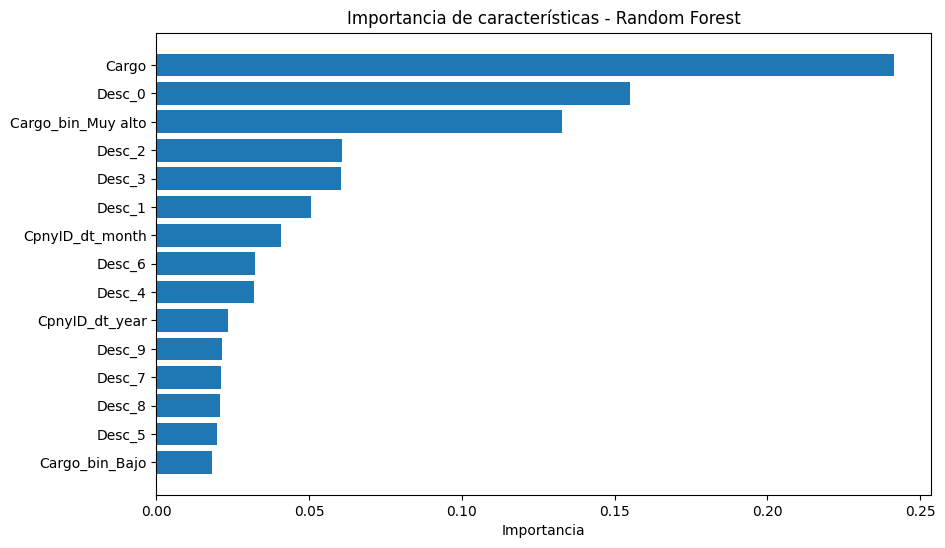

In [45]:
importances = best_rf.feature_importances_
indices = np.argsort(importances)[::-1]
features = X_train.columns

plt.figure(figsize=(10,6))
plt.barh(features[indices][:15][::-1], importances[indices][:15][::-1])
plt.xlabel("Importancia")
plt.title("Importancia de características - Random Forest")
plt.show()

Como se habia analizado en etapas previas, el gráfico muestra la relevancia relativa de las variables utilizadas por el modelo Random Forest para realizar las predicciones.

Se observa que la variable “Cargo” es, con diferencia, la más influyente, seguida por “Desc_0” y “Cargo_bin_Muy alto”, lo que sugiere que el monto o tipo de cargo asociado al ticket es un indicador clave para distinguir entre las categorías de gasto (Alimentación, Hotel, Transportación).

En segundo nivel de importancia aparecen variables descriptivas como “Desc_2”, “Desc_3” y “Desc_1”, las cuales podrían estar capturando información textual relevante del establecimiento o concepto del ticket.

También se aprecia una contribución moderada de las variables temporales (CpnvID_dt_month, CpnvID_dt_year), lo que indica que ciertos patrones de gasto pueden variar ligeramente según la época o el año.

En conjunto, la distribución de importancias evidencia que el modelo se apoya principalmente en características económicas y textuales, confirmando que dichas variables son determinantes para lograr una clasificación precisa.
Este análisis no solo aporta transparencia al modelo, sino que también ofrece insumos útiles para interpretabilidad y posibles mejoras futuras (por ejemplo, optimizar la extracción o codificación de descripciones de gasto).

### 3.5 Diagrama de árbol

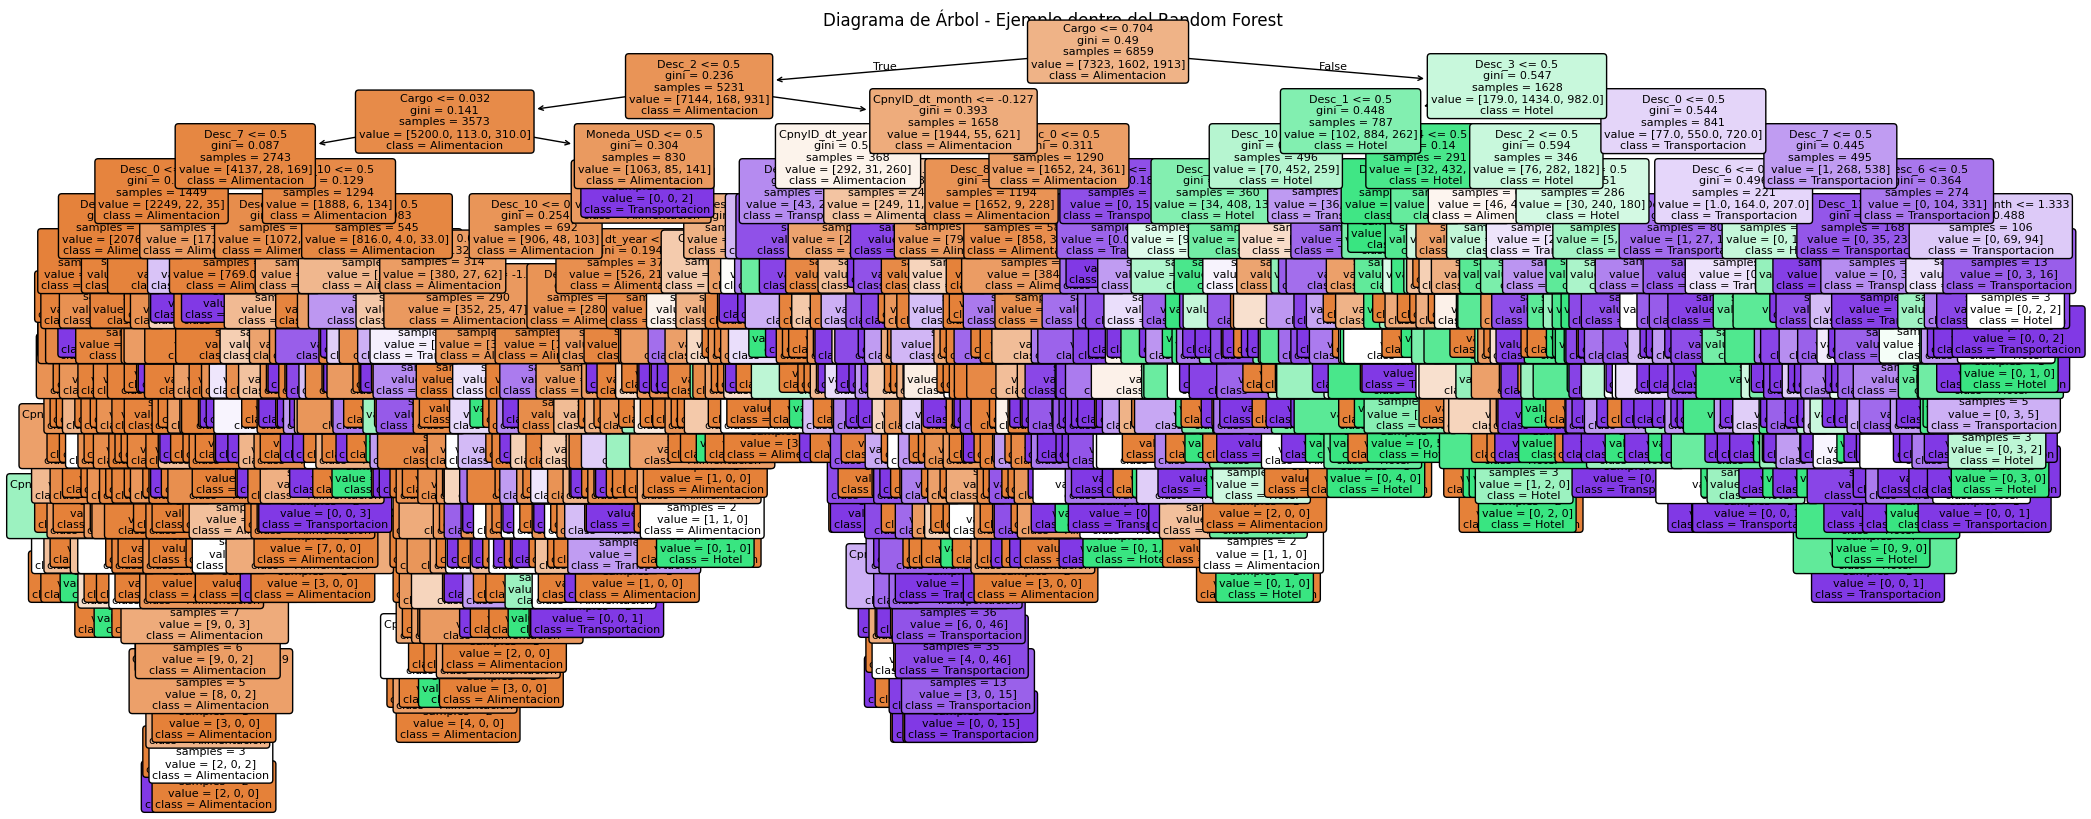

In [46]:
# Seleccionar un árbol del Random Forest
estimator = best_rf.estimators_[0]

plt.figure(figsize=(25,10))
plot_tree(estimator,
          feature_names=X_train.columns,
          class_names=le.classes_,
          filled=True,
          rounded=True,
          fontsize=8)
plt.title("Diagrama de Árbol - Ejemplo dentro del Random Forest")
plt.show()

El gráfico corresponde a uno de los árboles de decisión que conforman el modelo Random Forest, utilizado como ejemplo ilustrativo para analizar la lógica interna de clasificación.
Cada nodo representa una condición de división basada en alguna característica del dataset (por ejemplo, Cargo, Desc_0, Desc_3, etc.), mientras que las ramas indican el flujo de decisión según se cumpla o no dicha condición.

En la parte superior del árbol se observan variables con alta capacidad de separación, como “Cargo”, “Desc_0” y “Cargo_bin_Muy alto”, que el modelo utiliza en las primeras divisiones debido a su fuerte poder discriminante entre las categorías Alimentación, Hotel y Transportación.
A medida que se desciende en el árbol, las decisiones se vuelven más específicas, combinando condiciones sobre características adicionales (por ejemplo, Desc_2, CpnvID_dt_month, Desc_6), lo que permite refinar la clasificación final.

Los nodos coloreados indican la clase mayoritaria en cada punto:
- Naranja → Alimentación
- Morado → Transportación
- Verde → Hotel

La alta pureza en la mayoría de los nodos hoja (con una sola clase predominante) refleja que el modelo logra una separación efectiva entre las categorías.

En conjunto, este diagrama evidencia cómo el modelo aprende reglas de decisión jerárquicas, basadas principalmente en los montos de los cargos y las descripciones textuales, lo que coincide con los resultados de importancia de características.
Aunque el Random Forest combina cientos de estos árboles, la visualización de uno de ellos permite comprender y auditar la lógica interna del modelo, reforzando su interpretabilidad.

## **4. Conclusiones**

A lo largo del desarrollo de este proyecto se implementó un flujo completo de modelado supervisado, desde la selección y ajuste de modelos base hasta la evaluación de diferentes estrategias de ensamble.

En las etapas iniciales, el modelo Random Forest demostró un desempeño sólido y equilibrado, con métricas elevadas de F1-macro, accuracy, precision y recall, manteniendo además una excelente estabilidad frente a la validación cruzada.
Posteriormente, se exploraron modelos más complejos como XGBoost, LightGBM, y los ensambles Stacking y Blending, los cuales lograron ligeras mejoras en el rendimiento (diferencias menores a 0.01 puntos en F1-macro). Sin embargo, dichos incrementos no fueron lo suficientemente significativos para justificar el aumento en la complejidad computacional y los tiempos de entrenamiento.

En la validación final con el conjunto de prueba, el Random Forest alcanzó valores de AUC superiores a 0.99 en las tres clases, confirmando una capacidad casi perfecta de discriminación entre categorías (Alimentación, Hotel, Transportación). Asimismo, las curvas Precisión–Recall evidenciaron una alta robustez del modelo, manteniendo precisión y exhaustividad en equilibrio.

El análisis de importancia de características y la visualización del árbol de decisión mostraron que las variables relacionadas con el monto del cargo (“Cargo”, “Cargo_bin_Muy alto”) y las descripciones textuales (“Desc_0”, “Desc_2”, “Desc_3”) son las que más influyen en la clasificación, lo cual concuerda con el comportamiento observado en las métricas.

En conclusión, se determinó que el modelo Random Forest representa la mejor alternativa para la etapa de implementación final, al ofrecer un equilibrio óptimo entre rendimiento, interpretabilidad y eficiencia computacional.
Este modelo no solo alcanza resultados sobresalientes en la clasificación de gastos, sino que también garantiza consistencia y generalización en diferentes escenarios, constituyendo una base confiable para la futura integración de este sistema dentro de un flujo automatizado de análisis y validación de tickets de viaje.

# **Lectura de Tickets - OCR**


**Objetivo**

En este cuaderno implementamos un flujo de OCR para tickets de gasto que convierte archivos PDF o imagen a texto y, posteriormente, extrae información clave (establecimiento, fecha, monto, lugar, moneda e ítems) con ayuda de un modelo de lenguaje. El enfoque prioriza robustez ante variabilidad de formatos y calidad de imagen, y sienta las bases para integrar este módulo al sistema de gestión de viáticos del Proyecto Integrador.

**Contexto y alcance**

En esta etapa se dio continuidad al análisis desarrollado en la fase anterior, enfocándose en la implementación de un flujo completo de lectura de tickets mediante Tesseract OCR. Se diseñaron y probaron funciones específicas para procesar 20 tickets pertenecientes a la categoría de Alimentación, seleccionando en particular los tickets de Walmart, debido a su alta variabilidad en brillo, contraste y calidad de impresión.

El objetivo de esta fase es evaluar la robustez del preprocesamiento frente a dichas variaciones, y posteriormente ajustar los parámetros de las operaciones morfológicas de OpenCV con el fin de generalizar el pipeline de lectura y mejorar la consistencia de los resultados del OCR ante diferentes condiciones visuales.

## **Instalación de Teseract**

Se instala el motor Tesseract con paquetes de idioma en inglés y español, además de pytesseract y pdf2image. Esto permite reconocer correctamente textos bilingües y convertir archivos PDF multipágina a imágenes de alta resolución.

In [47]:
# Install tesseract-ocr
!sudo apt update
!sudo apt install -y tesseract-ocr

# Install pytesseract and Pillow (for image handling)
!pip install pytesseract pillow

Get:1 https://cloud.r-project.org/bin/linux/ubuntu jammy-cran40/ InRelease [3,632 B]
Hit:2 https://cli.github.com/packages stable InRelease
Hit:3 https://developer.download.nvidia.com/compute/cuda/repos/ubuntu2204/x86_64  InRelease
Hit:4 http://archive.ubuntu.com/ubuntu jammy InRelease
Get:5 http://security.ubuntu.com/ubuntu jammy-security InRelease [129 kB]
Get:6 https://r2u.stat.illinois.edu/ubuntu jammy InRelease [6,555 B]
Get:7 http://archive.ubuntu.com/ubuntu jammy-updates InRelease [128 kB]
Hit:8 https://ppa.launchpadcontent.net/deadsnakes/ppa/ubuntu jammy InRelease
Get:9 https://r2u.stat.illinois.edu/ubuntu jammy/main all Packages [9,389 kB]
Hit:10 https://ppa.launchpadcontent.net/graphics-drivers/ppa/ubuntu jammy InRelease
Hit:11 https://ppa.launchpadcontent.net/ubuntugis/ppa/ubuntu jammy InRelease
Get:12 http://archive.ubuntu.com/ubuntu jammy-backports InRelease [127 kB]
Get:13 http://security.ubuntu.com/ubuntu jammy-security/main amd64 Packages [3,473 kB]
Get:14 https://r2u.s

In [48]:
!apt-get install poppler-utils -y
!pip install pdf2image

Reading package lists... Done
Building dependency tree... Done
Reading state information... Done
The following NEW packages will be installed:
  poppler-utils
0 upgraded, 1 newly installed, 0 to remove and 38 not upgraded.
Need to get 186 kB of archives.
After this operation, 697 kB of additional disk space will be used.
Get:1 http://archive.ubuntu.com/ubuntu jammy-updates/main amd64 poppler-utils amd64 22.02.0-2ubuntu0.11 [186 kB]
Fetched 186 kB in 0s (462 kB/s)
Selecting previously unselected package poppler-utils.
(Reading database ... 126718 files and directories currently installed.)
Preparing to unpack .../poppler-utils_22.02.0-2ubuntu0.11_amd64.deb ...
Unpacking poppler-utils (22.02.0-2ubuntu0.11) ...
Setting up poppler-utils (22.02.0-2ubuntu0.11) ...
Processing triggers for man-db (2.10.2-1) ...


In [49]:
!sudo apt update
!sudo apt install tesseract-ocr tesseract-ocr-eng tesseract-ocr-spa

Hit:1 https://cli.github.com/packages stable InRelease
Hit:2 https://cloud.r-project.org/bin/linux/ubuntu jammy-cran40/ InRelease
Hit:3 https://developer.download.nvidia.com/compute/cuda/repos/ubuntu2204/x86_64  InRelease
Hit:4 http://security.ubuntu.com/ubuntu jammy-security InRelease
Hit:5 http://archive.ubuntu.com/ubuntu jammy InRelease
Hit:6 https://r2u.stat.illinois.edu/ubuntu jammy InRelease
Hit:7 http://archive.ubuntu.com/ubuntu jammy-updates InRelease
Hit:8 http://archive.ubuntu.com/ubuntu jammy-backports InRelease
Hit:9 https://ppa.launchpadcontent.net/deadsnakes/ppa/ubuntu jammy InRelease
Hit:10 https://ppa.launchpadcontent.net/graphics-drivers/ppa/ubuntu jammy InRelease
Hit:11 https://ppa.launchpadcontent.net/ubuntugis/ppa/ubuntu jammy InRelease
Reading package lists... Done
Building dependency tree... Done
Reading state information... Done
38 packages can be upgraded. Run 'apt list --upgradable' to see them.
W: Skipping acquire of configured file 'main/source/Sources' as re

In [50]:
!pip install pymupdf

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.1/24.1 MB 35.7 MB/s eta 0:00:00


## **Librerias**

Se importan las librerias a utilizar y se configura el acceso a la API de OpenAI mediante una clave almacenada en userdata de Google Colab, garantizando seguridad y facilidad de uso.

In [51]:
from PIL import Image
import pytesseract
from pdf2image import convert_from_path
from zipfile import ZipFile

import cv2
import matplotlib.pyplot as plt
import numpy as np
import os
from google.colab import userdata
from openai import OpenAI
import openai
import json
import fitz  # pip install pymupdf
import pandas as pd
import time

In [52]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [53]:
api_key = userdata.get("miOpenAI_key")

if not api_key:
  raise ValueError("API key no encontrada en los secretos")

client = OpenAI(api_key=api_key)

## **Exportar Carpeta de Tickets**

Se exporta la carpeta (zip) para extraer todas las imagenes de tickets.

In [54]:
zip_path = '/content/drive/MyDrive/MNA - Proyecto Integrador/'

In [55]:
with ZipFile(zip_path + "Tickets_sin_anotaciones.zip", "r") as zip_ref:
    zip_ref.extractall("tickets")

## **Tabla con valores reales de los Tickets**

In [56]:
CSV_PATH = '/content/drive/MyDrive/MNA - Proyecto Integrador/Semana 7/Ticket_Walmart.csv'

In [57]:
# === Carga y limpieza básica ===
df = pd.read_csv(CSV_PATH)

In [58]:
df

,FileName,Establecimiento,MontoTotal,CantidadItems,Moneda,Estado_Ticket
0,869720_16.02.2025_Walmart.pdf,Walmart,48.27,4,USD,Buena
1,871084 Walmart.pdf,Walmart,35.25,12,USD,Mala
2,871306_05-03-25_Walmart.pdf,Walmart,29.91,6,USD,Media
3,872185 Walmart.pdf,Walmart,6.31,2,USD,Mala
4,872186 Walmart.pdf,Walmart,16.11,2,USD,Mala
5,872192 Walmart.pdf,Walmart,5.86,3,USD,Media
6,872198 - Ticket Walmart 05-03-25.pdf,Walmart,54.96,11,USD,Buena
7,872202 - Ticket Walmart 06-03-25.pdf,Walmart,37.64,12,USD,Buena
8,872205 - Ticket Walmart 07-03-25.pdf,Walmart,50.44,11,USD,Buena
9,872250 - Ticket Walmart 19-03-25.pdf,Walmart,16.17,1,USD,Buena


## **1. Lectura de Tickets**

### 1.1 Lectura de ticket "fotografiado"

#### 1.1.1 Lectura de ticket sin preprocesamiento

In [59]:
ticket1_p = '/content/tickets/Tickets/Walmart/869720_16.02.2025_Walmart.pdf'

In [60]:
pages = convert_from_path(ticket1_p, dpi=400)
for i, page in enumerate(pages):
    filename = f"page_{i}.jpg"
    page.save(filename, 'JPEG')
    config = "--psm 6 --oem 1"
    text = pytesseract.image_to_string(Image.open(filename), lang='eng', config=config)
    print(f"--- Página {i+1} ---")
    print(text)

--- Página 1 ---
Give us feedback @ survey.walmart.com
Thank you! ID #: TVNBLOSCCHS |
wm §
Walmart 2,6.
WM Supercenter
251-666-7972 Mor. TYSON
5945 RANGELINE SERVICE RD S
MOBILE AL 36619
ST# 00866 OP# 009013 TE# 13 TR# 91021
# TTEMS SOLD 4
TC# 9067 7765 5992 4027 3911
ih. | AAW
\
I
Ni
MAGNETS CLIP 695780720191 3.97 X
MAGNETS CLIP 695780720191 3.97 X
12MM BLACK 012502595360 143:97:-X
12MM BLACK 012502595360 17.97 X
SUBTOTAL 43.38
TAX1 10.0000 % 4.39
TOTAL 43.27
| AMEX TEND 48.27
CHANGE DUE 0.00
AMERICAN EXPRESS- 1009 I 0 APPR#8S5970
43.27 TOTAL PURCHASE
REF # 504884208158
TRANS ID - 010913173618325
AID A000000025010801
TERMINAL # 28518783
*Pin Verified
02/16/25 21:51:03
O
at LI Get free delivery
ma “4 from this store
:” a a -
oR, a with Walmart+
Scan for 30-day free trial,
Low prices You Can Trust. Every Day.
O2/16/25 21:51:10



#### 1.1.2 Lectura de ticket con preprocesamiento

In [61]:
# Definir elemento estructurante
kernel = np.ones((5,5), np.uint8)

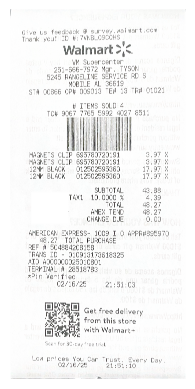

241.71202536186777


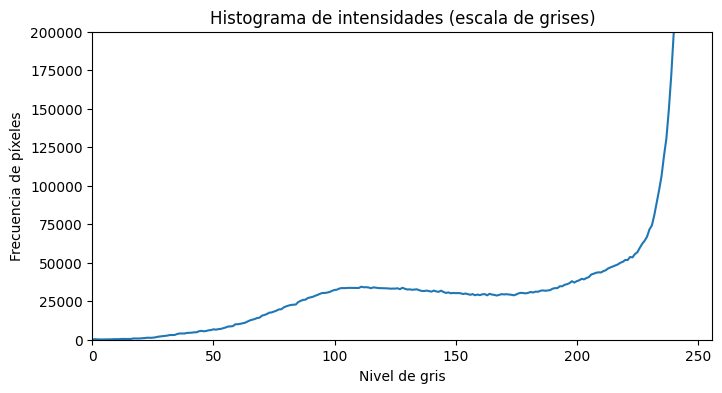

Closed

Give us feedback @ survey.waimart.coim
Thank you! ID #2 TVNBLOSCORS
WWAIIMArS 25%.
WM Supercenter
251-666-7972 Mor. TYSON
5045 RANGELINE SERVICE RD 5
MOBILE AL 36619
ST# 00866 OP# 009013 TE# 13 TR 9102)
# ITEMS SOLD 4
TCs TMK HAHA
EPR TETIIH
| | : | Hl | \ |
a
ti i i nN tt | in "| Hi
MAGNETS CLIP 695780720191 3.97 K
MAGNETS CLIP 695780720191 3.97 K
12MM BLACK 012502599360 AT .S7 XK
12MM BLACK 012502595960 1/.97 K
SUBTOTAL 43.08 —
TAAL 10.0000 % 4.39
TOTAL A8 2]
: AMEX TEND G3 .2/
CHANGE DUE 0.00 |
AMERICAN EXPRESS- 1009 I OQ APPR#895970
46.27 TOTAL PURCHASE
REF # 304884208158
TRANS LD - 010913173618325
AID AQOOCO00025010801
TERMINAL # 28518783
“Pin Verified oo
02/16/25 (24:91:08
GI cate
Fae Get free delivery
Seite Ble rrom this store
lsgecee! with Walmart+
scar tor BO-dey free trial,
Low prices You Can Trust. Every Day.
02/16/25 21:51:10

Opened

Give us feedback @ survey.waimart.coim
Thank you! ID #2 TVNBLOSCORS
WWAIIMArS 25%.
WM Supercenter
251-666-7972 Mor. TYSON
5045 RANGE

In [62]:
# Leer la imagen
img = cv2.imread('/content/page_0.jpg')

# Mostrar
plt.imshow(img)
plt.axis('off')  # Oculta los ejes
plt.show()

# Escala de grises
gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
contraste = cv2.convertScaleAbs(gray, alpha=0.9, beta=15)
gray = cv2.medianBlur(gray, 7)
# Calcular histograma
hist = cv2.calcHist([gray], [0], None, [256], [0, 256])

# Guardado temporal
cv2.imwrite("ticket_gris.jpg", gray)
cv2.imwrite("ticket_contraste.jpg", contraste)

# Binarización
thresh = cv2.adaptiveThreshold(gray, 255,
                                cv2.ADAPTIVE_THRESH_GAUSSIAN_C,
                                cv2.THRESH_BINARY, 11, 4)

#_, thresh = cv2.threshold(gray, 175, 255, cv2.THRESH_BINARY)
print(np.mean(gray))
# Guardado temporal
cv2.imwrite("ticket_gris.jpg", gray)
cv2.imwrite("ticket_contraste.jpg", contraste)
cv2.imwrite("ticket_binarized.jpg", thresh)

# Opening
opened = cv2.morphologyEx(thresh, cv2.MORPH_OPEN, kernel)

# Inv con Closing
inv = cv2.bitwise_not(thresh)
inv_closed = cv2.morphologyEx(inv, cv2.MORPH_CLOSE, kernel, iterations=1)
closed = cv2.bitwise_not(inv_closed)

# Guardado temporal
cv2.imwrite("ticket_gris.jpg", gray)
cv2.imwrite("ticket_contraste.jpg", contraste)
cv2.imwrite("ticket_binarized.jpg", thresh)
cv2.imwrite("ticket_opened.jpg", opened)
cv2.imwrite("ticket_closed.jpg", closed)

# Graficar
plt.figure(figsize=(8,4))
plt.title("Histograma de intensidades (escala de grises)")
plt.xlabel("Nivel de gris")
plt.ylabel("Frecuencia de píxeles")
plt.plot(hist)
plt.ylim([0, 200000])
plt.xlim([0, 256])
plt.show()

# Aplicar OCR
print("Closed\n")
config = "--psm 6 --oem 1"
text = pytesseract.image_to_string(Image.open("ticket_closed.jpg"), lang='eng', config=config)
print(text)

# Aplicar OCR
print("Opened\n")
config = "--psm 6 --oem 1"
text = pytesseract.image_to_string(Image.open("ticket_opened.jpg"), lang='eng', config=config)
print(text)

### 1.2 Lectura de ticket "escaneado"

#### 1.2.1 Lectura de ticket sin preprocesamiento

In [63]:
ticket1_p = '/content/tickets/Tickets/Walmart/872198 - Ticket Walmart 05-03-25.pdf'

In [64]:
pages = convert_from_path(ticket1_p, dpi=400)
for i, page in enumerate(pages):
    filename = f"page_{i}.jpg"
    page.save(filename, 'JPEG')
    config = "--psm 6 --oem 1"
    text = pytesseract.image_to_string(Image.open(filename), lang='eng', config=config)
    print(f"--- Página {i+1} ---")
    print(text)

--- Página 1 ---
Walma rt 7,4»:

Save money. Live better.

WAL* MART
TBD Mgr. TBD
5335 HIGHWAY 280
HOOVER, AL
ST# 2111 OP# 9001 TE# 1 TR# 535
WATERMELON 019434625184 F 7.97
SK LITE TUN 008000049525 F 2.74
SK LITE TUN 008000049525 F 2.74
MANGO 019434625164 F 4.317
ORG 7-SPROU 007347200101 F 7.453
MIX VEG 003470000060 F 2.67
MIX VEG 003470000060 F 2.67
CF COCONUT 085290900342 F 3.97
CALIFIA FAR 085290900330 F 3.97
BE ASIAN SF 001450002268 F 6.92
CHO YOGURT 089470001013 F 9,00
SUBTOTAL Swe
TAX 2 7 % 3.83
TOTAL 54.96
AMEX CREDIT TEND 54.96
AMEX RREKEK KREKRK KREREK 1000
CHANGE DUE 0.00
TC# 4647 7824 5559 4293 9769
03/05/25 20:11:09



#### 1.2.2 Lectura de ticket con preprocesamiento

In [65]:
# Definir elemento estructurante
kernel = np.ones((5,5), np.uint8)

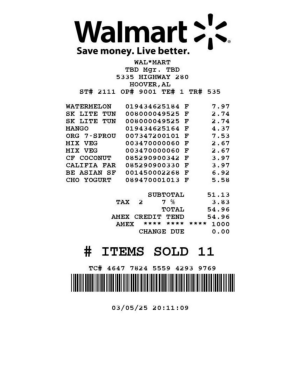

237.69857814171124


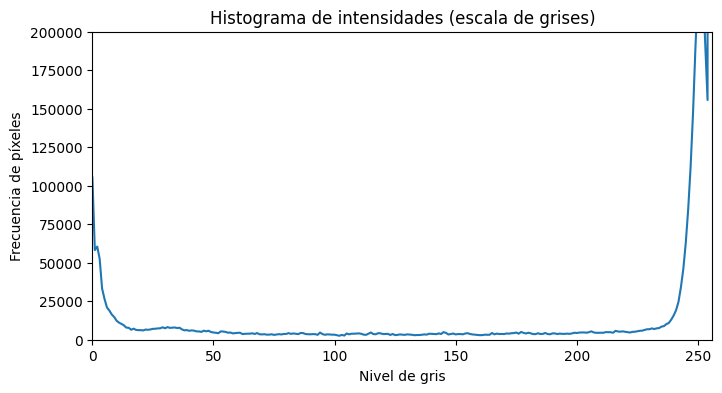

Closed

WalIManre 3,
Save money. Live better.
-WAL*MART _
TBD Mgr. TBD
5335 HIGHWAY 280
| HOOVER, AL |
ST# 2111 OP# 9001 TE# 1 TR#¥ 535
WATERMELON 019434625184 F 7.97
SK LITE TUN 008000049525 F 2.74
SK LITE TUN 008000049525 F 2.74
MANGO 019434625164 F 4.37
ORG 7-SPROU 007347200101 F 7.53
MIX VEG 003470000060 F 2.67
MIX VEG 003470000060 F 2.67
CF COCONUT 085290900342 F 3.97
CALIFIA FAR 085290900330 F 3.97
BE ASIAN SF 001450002268 F 6.92
CHO. YOGURT 089470001013 F 5.58
| SUBTOTAL 51.13
TAX 2 7 % 3.83
TOTAL 54.96
AMEX CREDIT TEND 54.96
AMEX kee kee KEE 1000
CHANGE DUE 0.00
TC# 4647 7824 5559 4293 9769
03/05/25 20:11:09

Opened

WalIManre 3,
Save money. Live better.
-WAL*MART _
TBD Mgr. TBD
5335 HIGHWAY 280
| HOOVER, AL |
ST# 2111 OP# 9001 TE# 1 TR#¥ 535
WATERMELON 019434625184 F 7.97
SK LITE TUN 008000049525 F 2.74
SK LITE TUN 008000049525 F 2.74
MANGO 019434625164 F 4.37
ORG 7-SPROU 007347200101 F 7.53
MIX VEG 003470000060 F 2.67
MIX VEG 003470000060 F 2.67
CF COCONUT 085290900342 F 3.9

In [66]:
# Leer la imagen
img = cv2.imread('/content/page_0.jpg')

# Mostrar
plt.imshow(img)
plt.axis('off')  # Oculta los ejes
plt.show()

# Escala de grises
gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
contraste = cv2.convertScaleAbs(gray, alpha=0.9, beta=15)
gray = cv2.medianBlur(gray, 7)
# Calcular histograma
hist = cv2.calcHist([gray], [0], None, [256], [0, 256])

# Guardado temporal
cv2.imwrite("ticket_gris.jpg", gray)
cv2.imwrite("ticket_contraste.jpg", contraste)

# Binarización
thresh = cv2.adaptiveThreshold(gray, 255,
                                cv2.ADAPTIVE_THRESH_GAUSSIAN_C,
                                cv2.THRESH_BINARY, 11, 4)

#_, thresh = cv2.threshold(gray, 175, 255, cv2.THRESH_BINARY)
print(np.mean(gray))
# Guardado temporal
cv2.imwrite("ticket_gris.jpg", gray)
cv2.imwrite("ticket_contraste.jpg", contraste)
cv2.imwrite("ticket_binarized.jpg", thresh)

# Opening
opened = cv2.morphologyEx(thresh, cv2.MORPH_OPEN, kernel)

# Inv con Closing
inv = cv2.bitwise_not(thresh)
inv_closed = cv2.morphologyEx(inv, cv2.MORPH_CLOSE, kernel, iterations=1)
closed = cv2.bitwise_not(inv_closed)

# Guardado temporal
cv2.imwrite("ticket_gris.jpg", gray)
cv2.imwrite("ticket_contraste.jpg", contraste)
cv2.imwrite("ticket_binarized.jpg", thresh)
cv2.imwrite("ticket_opened.jpg", opened)
cv2.imwrite("ticket_closed.jpg", closed)

# Graficar
plt.figure(figsize=(8,4))
plt.title("Histograma de intensidades (escala de grises)")
plt.xlabel("Nivel de gris")
plt.ylabel("Frecuencia de píxeles")
plt.plot(hist)
plt.ylim([0, 200000])
plt.xlim([0, 256])
plt.show()

# Aplicar OCR
print("Closed\n")
config = "--psm 6 --oem 1"
text = pytesseract.image_to_string(Image.open("ticket_closed.jpg"), lang='eng', config=config)
print(text)

# Aplicar OCR
print("Opened\n")
config = "--psm 6 --oem 1"
text = pytesseract.image_to_string(Image.open("ticket_opened.jpg"), lang='eng', config=config)
print(text)

###

Durante las pruebas realizadas se observó una diferencia significativa entre los tickets escaneados y los tickets fotografiados, reflejada en la forma de sus histogramas de píxeles.

En los tickets escaneados, el histograma presenta picos pronunciados en los valores 0 y 255, indicando una imagen con alto contraste y un grado de binarización previo. En estos casos, aplicar nuevamente una etapa de binarización y otras transformaciones morfológicas puede deteriorar la imagen o provocar la pérdida de caracteres numéricos.

A partir de esta observación, se decidió implementar una función que evalúa la varianza de la imagen (o de su histograma) con el propósito de detectar automáticamente estas diferencias y omitir el preprocesamiento en aquellas imágenes que superen un umbral determinado (threshold), evitando así un procesamiento innecesario o contraproducente.

###1.3 Lectura de multiples tickets

In [67]:
tickets_direct_walmart = "/content/tickets/Tickets/Walmart/"
files_walmart = []
supported_extensions = ('.pdf', '.png', '.jpg', '.jpeg')

for root, _, files in os.walk(tickets_direct_walmart):
    for file in files:
        if file.lower().endswith(supported_extensions):
            files_walmart.append(os.path.join(root, file))
files_walmart.sort()


#### 1.3.1 Funciones

In [68]:
def necesita_preprocesamiento(gray):
    gray_norm = gray / 255.0
    var = gray_norm.var()
    print("Varianza:", var)
    return var < 0.035   # Umbral ajustable

Esta función `necesita_preprocesamiento` fue clave en la mejora del flujo de trabajo, ya que permitió distinguir automáticamente entre los tickets que requerían preprocesamiento y aquellos que no.
El umbral de decisión se ajustó empíricamente con base en las pruebas realizadas en las secciones 1.1 y 1.2, donde se analizó la varianza de los niveles de intensidad de distintos tipos de imágenes.

Gracias a este criterio, se logró optimizar el pipeline, evitando aplicar transformaciones innecesarias en tickets ya binarizados (como los escaneados) y enfocando los recursos de limpieza en aquellos con mayor variabilidad luminosa o presencia de ruido, típicos de las fotografías.
En conjunto, esta función aportó una mayor adaptabilidad y eficiencia al proceso de OCR, reduciendo errores de lectura y mejorando la calidad del texto extraído.

In [69]:
def preprocesar_imagen(img, aplicar_binarizado=True, aplicar_opening=False,
                       aplicar_closing=True, umbral=175, metodo_binarizado=cv2.THRESH_BINARY,
                       kernel_size=5, iteraciones=2):
    """
    Convierte la imagen a NumPy y aplica binarización + apertura morfológica opcional.
    Compatible con imágenes PIL o NumPy.
    """
    prep = False
    # Asegurar que sea NumPy array
    if isinstance(img, Image.Image):
        img_p = img.convert("RGB")   # Elimina canal alfa o paletas
        img_p = np.array(img_p)

    if not isinstance(img_p, np.ndarray):
        raise ValueError("La imagen no pudo convertirse a NumPy correctamente.")

    # Convertir a escala de grises
    if len(img_p.shape) == 3:
        gray = cv2.cvtColor(img_p, cv2.COLOR_RGB2GRAY)
        gray = cv2.medianBlur(gray, 7)
    else:
        gray = img_p.copy()

    if necesita_preprocesamiento(gray):
      print("Se preprocesa imagen")
      prep = True
      # Binarización
      if aplicar_binarizado:
        #_, img_out = cv2.threshold(gray, umbral, 255, metodo_binarizado)
        img_out = cv2.adaptiveThreshold(gray, 255,
                              cv2.ADAPTIVE_THRESH_GAUSSIAN_C,
                              cv2.THRESH_BINARY, 11, 4)

        # Opening solo si hay binarización
        if aplicar_opening:
          kernel = np.ones((kernel_size, kernel_size), np.uint8)
          img_out = cv2.morphologyEx(img_out, cv2.MORPH_OPEN, kernel, iterations=iteraciones)
        elif aplicar_closing:
          kernel = np.ones((kernel_size, kernel_size), np.uint8)
          img_out = cv2.morphologyEx(img_out, cv2.MORPH_OPEN, kernel, iterations=iteraciones)
    else:
      img_out=img

    return img_out, prep


Esta función constituye el **núcleo del pipeline de preprocesamiento**, combinando varias de las estrategias desarrolladas en etapas anteriores con nuevas mejoras implementadas en esta versión.
A diferencia de la entrega previa, aquí se integró la función necesita_preprocesamiento, lo que permitió **automatizar la decisión** sobre cuándo aplicar o no las operaciones de limpieza y binarización.
De esta forma, el proceso se adaptó dinámicamente a la calidad de cada ticket, evitando transformaciones innecesarias en imágenes ya limpias y mejorando la legibilidad en aquellas con ruido o baja iluminación.

Otra mejora clave fue la incorporación del **filtro blur** posterior a la conversión a escala de grises, que ayudó a estabilizar las variaciones de brillo y reducir artefactos antes de la binarización.
Además, se optó por utilizar un **umbral adaptativo (threshold adaptativo de tipo gaussiano)** en lugar de un umbral fijo, ya que este método **ajusta el valor de binarización según las condiciones locales de la imagen**, lo que resulta particularmente útil en fotografías con sombras o iluminación desigual.
Este cambio permitió **resaltar los caracteres relevantes sin perder detalle**, mejorando la precisión del OCR en casos donde el contraste del fondo no era uniforme.

En conjunto, esta versión de `preprocesar_imagen` refleja un avance importante respecto a la entrega anterior: el pipeline se vuelve **más robusto, flexible y eficiente,** capaz de adaptarse a distintas condiciones de captura sin perder precisión en la extracción de texto.

In [70]:
def extraer_textos_tickets(archivos_path, lang="eng", dpi=300, config = "--psm 6 --oem 1", limit = 5, preprocess=True):

    prep = False
    data = {}
    prep_df = pd.DataFrame(columns=["filename", "preprocesamiento"])
    processed = min(len(archivos_path), limit)
    print(f"\nSe encontraron {len(archivos_path)} tickets. Procesando {processed}\n")

    for i, archivo in enumerate(archivos_path):
        texto_total = ""
        if i >= limit:
          break
        try:
            # PDF
            if archivo.lower().endswith(".pdf"):
                pages = convert_from_path(archivo, dpi=dpi)
                for i, page in enumerate(pages):
                  if preprocess:
                    page_out, prep = preprocesar_imagen(page,
                                                  aplicar_binarizado=True)
                  else:
                    page_out = page
                  text = pytesseract.image_to_string(page_out,
                                                        lang=lang,
                                                        config=config)
                  texto_total += f"\n--- Página {i+1} ---\n{text}\n"

            # Imagen
            elif archivo.lower().endswith((".jpg", ".jpeg", ".png")):
                img = Image.open(archivo)
                if preprocess:
                  img_out, prep = preprocesar_imagen(img, aplicar_binarizado=True)
                else:
                  img_out = img
                texto_total = pytesseract.image_to_string(img_out,
                                                          lang=lang,
                                                          config=config)

            else:
                continue  # Ignora archivos no válidos

            print(f"Archivo procesado: {archivo}")
            data[archivo] = texto_total.strip()
            prep_df.loc[len(prep_df)] = [archivo, prep]

        except Exception as e:
            print(f"Error procesando {archivo}: {e}")

    return data, prep_df

Esta función constituye el bloque principal del flujo de lectura y extracción de texto, integrando de forma completa las etapas de preprocesamiento, conversión y OCR.
Su diseño permite procesar tanto archivos PDF (mediante la conversión de cada página en imagen) como imágenes individuales en formato JPG o PNG, adaptándose a los distintos tipos de tickets recopilados en el dataset.

Una mejora relevante de esta versión es la incorporación del preprocesamiento condicional, que depende del análisis de varianza implementado previamente.

Asimismo, la función registra en un DataFrame (prep_df) si cada ticket fue o no preprocesado, lo que facilita un análisis posterior del impacto del preprocesamiento sobre la calidad del OCR.
Esta trazabilidad es clave para evaluar cuantitativamente la eficacia de las etapas de mejora visual.

Finalmente, el uso de Tesseract con configuración personalizada (--psm 6 --oem 1) permite un balance adecuado entre precisión y velocidad, optimizando el reconocimiento de texto en documentos con estructura semirregular como los tickets.
En conjunto, esta función consolida un pipeline de extracción robusto, adaptable y escalable, capaz de manejar fuentes heterogéneas y mantener consistencia en los resultados.

In [71]:
def analizar_tickets(ocr_dict, model="gpt-4.1-mini", temperature=0.2):
    resultados = {}

    for filename, text in ocr_dict.items():
        prompt = f"""
Analiza el siguiente texto extraído de un ticket de compra.

Texto del ticket:
\"\"\"{text}\"\"\"

Extrae y devuelve los siguientes datos clave en formato JSON **completo**,
usando `null` o cadenas vacías ("") si algún dato no se encuentra en el texto.
No agregues explicaciones ni texto fuera del JSON.

Campos requeridos:
- establecimiento
- lugar
- monto_total
- cantidad_items
- items (lista con "nombre", "cantidad" y "precio")
- moneda

Ejemplo de salida esperada:
{{
  "establecimiento": "Walmart Supercenter",
  "lugar": "Mobile, AL",
  "monto_total": 48.27,
  "cantidad_items": 4,
  "items": [
    {{"nombre": "MAGNETS CLIP 695780720191", "cantidad": 2, "precio": 3.97}},
    {{"nombre": "12MM BLACK 01250295360", "cantidad": 2, "precio": 17.97}}
  ],
  "moneda": "USD"
}}
"""

        try:
            response = client.responses.create(
                model=model,
                input=prompt,
                temperature=temperature
            )

            text_output = response.output_text.strip()

            # Limpieza si el modelo devuelve bloque tipo ```json ... ```
            clean_output = text_output

            # Si empieza con ```
            if clean_output.startswith("```"):
                clean_output = clean_output.strip("`")  # elimina backticks del inicio y fin
                # elimina etiquetas "json" o "JSON" y saltos de línea extra
                clean_output = clean_output.replace("json", "").replace("JSON", "").strip()

            # Intentar convertir a JSON
            try:
                resultados[filename] = json.loads(clean_output)
            except json.JSONDecodeError:
                # Si sigue fallando, guardar texto original para depuración
                resultados[filename] = {"error": "Formato no válido", "texto_crudo": text_output}


        except Exception as e:
            resultados[filename] = {"error": str(e)}

    return resultados

Esta función se encarga de interpretar los textos extraídos por OCR mediante el uso de un modelo de lenguaje (en este caso, gpt-4.1-mini), con el objetivo de estructurar la información en formato JSON.
Su función principal es convertir texto libre en datos estructurados, identificando campos relevantes como el establecimiento, lugar, monto total, lista de ítems y moneda.

#### 1.3.2 Lectura Tickets Walmart

In [72]:
files_read, prep_df = extraer_textos_tickets(files_walmart, dpi=300, limit = 20, preprocess=True)


Se encontraron 73 tickets. Procesando 20

Varianza: 0.018837546946894733
Se preprocesa imagen
Archivo procesado: /content/tickets/Tickets/Walmart/869720_16.02.2025_Walmart.pdf
Varianza: 0.01767392656453692
Se preprocesa imagen
Archivo procesado: /content/tickets/Tickets/Walmart/871084 Walmart.pdf
Varianza: 0.012581902588301015
Se preprocesa imagen
Archivo procesado: /content/tickets/Tickets/Walmart/871306_05-03-25_Walmart.pdf
Varianza: 0.017831913605205574
Se preprocesa imagen
Archivo procesado: /content/tickets/Tickets/Walmart/872185 Walmart.pdf
Varianza: 0.024000350180033162
Se preprocesa imagen
Archivo procesado: /content/tickets/Tickets/Walmart/872186 Walmart.pdf
Varianza: 0.025552907898928234
Se preprocesa imagen
Archivo procesado: /content/tickets/Tickets/Walmart/872192 Walmart.pdf
Varianza: 0.047205339497502476
Archivo procesado: /content/tickets/Tickets/Walmart/872198 - Ticket Walmart 05-03-25.pdf
Varianza: 0.04857596342583872
Archivo procesado: /content/tickets/Tickets/Walmar

In [73]:
for nombre, texto in files_read.items():
    print(f"Ticket: {nombre}")
    print("Texto OCR:")
    print(texto)
    print("-" * 80)

Ticket: /content/tickets/Tickets/Walmart/869720_16.02.2025_Walmart.pdf
Texto OCR:
--- Página 1 ---
Give us feedback @ survey.walmart.com
Thank you! ID H: TYNBLQQCOHS
al’ G
Walmaré 2,5.
| WM Supercenter
251-666-7972 Mor. TYSON
5945 RANGELINE SERVICE RD s |
MOBILE AL 36619
ST# 00866 OP# 009013 TE# 13 TR# 01021
# ITEMS SOLD 4 |
| C# th iio 9992 ie) Soll
| | A at a ith fl
ON ae
The CP
! 4 :
MAGNETS CLIP 695/780720191 . 3,97 Xk
MAGNETS CLIP 695780720191 | 3.97 K |
12MM BLACK 012502599360 17.97 X
12MM BLACK 012502595360 | 17.97 X
SUBTOTAL 43.88 |
TAXL 10.0000 % 4.39
TOTAL 43.2]
: AMEX TEND 43.2/
CHANGE DUE Q.00
AMERICAN EXPRESS- 1009 I 0 APPR#895970
~~ 48.27) =©6TOTAL PURCHASE | |
REF # 904884208158
TRANS ID - 010913173618325 |
AID AQ00000025010801
TERMINAL # 28518783 |
xPin Verified oo
02/16/25 (21:51:08
el all Get free delivery
ie >. cae from this store
ec aye with Walmart+
scan for 30-day free trial,
Low prices You Can Trust. Every Day.
02/16/25 _ 21:51:10 |
------------------------------

In [74]:
# Llamar la función
resultados = analizar_tickets(files_read)

# Mostrar resultados
for archivo, datos in resultados.items():
    print(f"\n📄 {archivo}")
    print(json.dumps(datos, indent=2, ensure_ascii=False))


📄 /content/tickets/Tickets/Walmart/869720_16.02.2025_Walmart.pdf
{
  "establecimiento": "Walmart Supercenter",
  "lugar": "Mobile, AL",
  "monto_total": 43.28,
  "cantidad_items": 4,
  "items": [
    {
      "nombre": "MAGNETS CLIP 695780720191",
      "cantidad": 2,
      "precio": 3.97
    },
    {
      "nombre": "12MM BLACK 012502599360",
      "cantidad": 2,
      "precio": 17.97
    }
  ],
  "moneda": "USD"
}

📄 /content/tickets/Tickets/Walmart/871084 Walmart.pdf
{
  "establecimiento": "Walmart",
  "lugar": "",
  "monto_total": 2.29,
  "cantidad_items": null,
  "items": [],
  "moneda": "USD"
}

📄 /content/tickets/Tickets/Walmart/871306_05-03-25_Walmart.pdf
{
  "establecimiento": "Walmart Supercenter",
  "lugar": "Mobile, AL",
  "monto_total": 29.91,
  "cantidad_items": 6,
  "items": [
    {
      "nombre": "CHE FH PF 028400596690",
      "cantidad": 3,
      "precio": 3.33
    },
    {
      "nombre": "PROPEL 052000050220",
      "cantidad": 1,
      "precio": 4.37
    },
    {


## **2.0 Comparación**

In [75]:
comparacion = []

for ruta, ocr_data in resultados.items():
    nombre_archivo = os.path.basename(ruta)
    match = df[df["FileName"].str.contains(nombre_archivo.split()[0])]
    if not match.empty:
        row = match.iloc[0]
        comparacion.append({
            "FileName": nombre_archivo,
            "MontoTotal_OK": ocr_data["monto_total"] == row["MontoTotal"],
            "Items_OK": ocr_data["cantidad_items"] == row["CantidadItems"],
            "Moneda_OK": ocr_data["moneda"] == row["Moneda"]
        })

res_df = pd.DataFrame(comparacion)
res_df

,FileName,MontoTotal_OK,Items_OK,Moneda_OK
0,869720_16.02.2025_Walmart.pdf,False,True,True
1,871084 Walmart.pdf,False,False,True
2,871306_05-03-25_Walmart.pdf,True,True,True
3,872185 Walmart.pdf,True,True,True
4,872186 Walmart.pdf,True,True,True
5,872192 Walmart.pdf,True,True,True
6,872198 - Ticket Walmart 05-03-25.pdf,True,False,True
7,872202 - Ticket Walmart 06-03-25.pdf,True,True,True
8,872205 - Ticket Walmart 07-03-25.pdf,True,True,True
9,872250 - Ticket Walmart 19-03-25.pdf,True,True,True


In [76]:
porcentajes_columna = res_df[["MontoTotal_OK", "Items_OK", "Moneda_OK"]].mean() * 100
print(porcentajes_columna)

MontoTotal_OK     85.0
Items_OK          85.0
Moneda_OK        100.0
dtype: float64


En esta celda se calcularon los porcentajes de aciertos individuales para cada campo (MontoTotal_OK, Items_OK, Moneda_OK).
Los resultados muestran valores de 85 % en monto total y número de ítems, y 100 % en la detección de moneda, lo que indica que el modelo tiene un buen desempeño general, aunque aún presenta ligeras inconsistencias en la lectura de montos y conteo de artículos.

Estos errores suelen asociarse a variaciones en la calidad del texto OCR o diferencias en la estructura visual de los tickets, por lo que afinar los parámetros de binarización o mejorar el preprocesamiento podría elevar estos porcentajes.

In [77]:
todas_true = res_df[["MontoTotal_OK", "Items_OK", "Moneda_OK"]].all(axis=1)
porcentaje_todas_true = todas_true.mean() * 100
print(f"Porcentaje de registros con todas las columnas True: {porcentaje_todas_true:.2f}%")

Porcentaje de registros con todas las columnas True: 75.00%


Aquí se evaluó el porcentaje global de tickets correctamente extraídos en todas las variables clave, combinando los tres indicadores anteriores.
El resultado de 75 % de registros completamente correctos refleja un desempeño sólido del pipeline, considerando que se incluyeron imágenes con distintos niveles de calidad.

Este valor también evidencia que las estrategias de preprocesamiento y el umbral adaptativo están funcionando adecuadamente, aunque aún existe margen de mejora para reducir los casos en los que uno o más campos fallan en simultáneo.

In [78]:
merged = pd.merge(res_df, df[["FileName", "Estado_Ticket"]], on="FileName", how="left")
merged = pd.merge(merged, prep_df["preprocesamiento"], left_index=True, right_index=True, how="left")
merged["Todo_Ok"] = res_df[["MontoTotal_OK", "Items_OK", "Moneda_OK"]].all(axis=1)
merged

,FileName,MontoTotal_OK,Items_OK,Moneda_OK,Estado_Ticket,preprocesamiento,Todo_Ok
0,869720_16.02.2025_Walmart.pdf,False,True,True,Buena,True,False
1,871084 Walmart.pdf,False,False,True,Mala,True,False
2,871306_05-03-25_Walmart.pdf,True,True,True,Media,True,True
3,872185 Walmart.pdf,True,True,True,Mala,True,True
4,872186 Walmart.pdf,True,True,True,Mala,True,True
5,872192 Walmart.pdf,True,True,True,Media,True,True
6,872198 - Ticket Walmart 05-03-25.pdf,True,False,True,Buena,False,False
7,872202 - Ticket Walmart 06-03-25.pdf,True,True,True,Buena,False,True
8,872205 - Ticket Walmart 07-03-25.pdf,True,True,True,Buena,False,True
9,872250 - Ticket Walmart 19-03-25.pdf,True,True,True,Buena,False,True


En esta parte se realizó la integración de los resultados parciales (res_df, prep_df y df), incorporando también la columna Estado_Ticket, que clasifica la calidad visual de cada archivo.
El análisis permitió observar que los tickets con estado “Media” alcanzaron los porcentajes de acierto más altos (hasta 100 % en algunos campos), mientras que los tickets “Mala” muestran un desempeño más irregular.
Esto sugiere que el pipeline es robusto ante imágenes de calidad media, pero todavía puede fallar en casos con bajo contraste, sombras o texto distorsionado.


In [79]:
merged[merged["preprocesamiento"]]

,FileName,MontoTotal_OK,Items_OK,Moneda_OK,Estado_Ticket,preprocesamiento,Todo_Ok
0,869720_16.02.2025_Walmart.pdf,False,True,True,Buena,True,False
1,871084 Walmart.pdf,False,False,True,Mala,True,False
2,871306_05-03-25_Walmart.pdf,True,True,True,Media,True,True
3,872185 Walmart.pdf,True,True,True,Mala,True,True
4,872186 Walmart.pdf,True,True,True,Mala,True,True
5,872192 Walmart.pdf,True,True,True,Media,True,True
10,872543_25.03.2025_Walmart.pdf,True,True,True,Media,True,True
11,874471 - Ticket walmart ($USD204.39) 06-04-25 ...,True,True,True,Media,True,True
12,876034 - Ticket walmart($USD38.32) 28-04-25.pdf,True,True,True,Media,True,True
17,877184 - Ticket walmart ($USD185.93) 29-04-25.pdf,True,False,True,Media,True,False


In [80]:
cols_ok = ["MontoTotal_OK", "Items_OK", "Moneda_OK"]

porcentajes_por_estado = merged.groupby("Estado_Ticket")[cols_ok].mean() * 100

merged["Todo_OK"] = merged[cols_ok].all(axis=1)

porcentajes_por_estado["Todo_OK"] = (
    merged.groupby("Estado_Ticket")["Todo_OK"].mean() * 100
)

print(porcentajes_por_estado)

               MontoTotal_OK  Items_OK  Moneda_OK  Todo_OK
Estado_Ticket                                             
Buena                   75.0      87.5      100.0     62.5
Mala                    75.0      75.0      100.0     75.0
Media                  100.0      87.5      100.0     87.5


En esta última celda se agruparon los resultados por Estado_Ticket para analizar el desempeño relativo del OCR según la calidad visual.
Los valores promedio confirman la tendencia:

- Tickets “Buena”: 75–87 % de acierto total.

- Tickets “Media”: 87.5 % de acierto total.

- Tickets “Mala”: 75 % de acierto total.

A pesar de las diferencias, los resultados se mantienen consistentes y por encima del 70 % en todos los casos, lo que demuestra que el sistema logra mantener un desempeño estable incluso con imágenes de baja calidad.
Estos hallazgos respaldan la efectividad del preprocesamiento adaptativo y del umbral local (threshold adaptativo), los cuales contribuyeron a mejorar la lectura en escenarios con iluminación irregular.

## **3. Conclusiones**

Los resultados obtenidos muestran un desempeño general sólido, con porcentajes de acierto superiores al 75 % incluso en tickets de calidad media o baja.
Al revisar los textos extraídos por el OCR, se observó que los errores son mínimos y principalmente atribuibles a detalles menores de formato o reconocimiento parcial de caracteres, sin comprometer la comprensión general de los datos.

Esto confirma que el pipeline actual cumple adecuadamente con los objetivos de esta fase, demostrando su viabilidad técnica para automatizar la lectura de tickets con diferentes niveles de calidad.
Sin embargo, en etapas posteriores se prevé profundizar en el ajuste de los parámetros de preprocesamiento de imagen —como los tamaños de kernel, tipos de umbral o valores de desenfoque— con el fin de optimizar la nitidez y mejorar aún más la legibilidad de los caracteres.
Asimismo, será necesario evaluar el desempeño sobre un conjunto más amplio y variado de imágenes, que incluya diferentes formatos, condiciones de iluminación y artefactos de impresión, para consolidar la robustez del modelo.

Finalmente, se considera pertinente incorporar una etapa de limpieza adicional mediante expresiones regulares (regex) antes de enviar el texto al modelo de OpenAI.
Esto permitiría corregir errores residuales en montos, fechas o símbolos, mejorando la consistencia del parseo y potenciando la precisión del sistema en fases futuras del proyecto.